# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.51KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

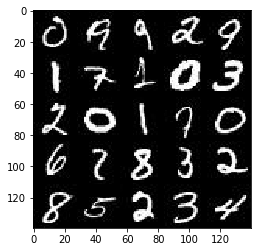

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

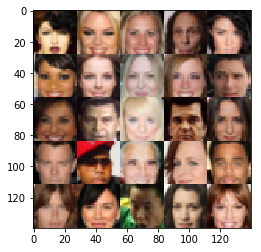

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32,(None, image_width,image_height,image_channels))
    z_input = tf.placeholder(tf.float32,(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    
    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    leaky_relu_alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):

        #print("images shape: ", images.shape)
        # Input layer is 28x28x3
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        leaky_relu1 = tf.maximum(leaky_relu_alpha * x1, x1)
        #print("leaky_relu1 shape: ", leaky_relu1.shape)
        # 14x14x64
        
        x2 = tf.layers.conv2d(leaky_relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(leaky_relu_alpha * bn2, bn2)
        #print("relu2 shape: ", relu2.shape)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(leaky_relu_alpha * bn3, bn3)
        #print("relu3 shape: ", relu3.shape)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    leaky_relu_alpha=0.2
    
    #reuse the variables if not training
    with tf.variable_scope('generator', reuse=not is_train):
        
        #print("z shape: ", z.shape )
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(leaky_relu_alpha * x1, x1)
        #print("x1 shape: ", x1.shape)
        # 7x7x256 now
        
        # Using a stride of one to preserve the width and height at this step
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(leaky_relu_alpha * x2, x2)
        #print("x2 shape: ", x2.shape)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(leaky_relu_alpha * x3, x3)
        #print("x3 shape: " , x3.shape);
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #print("logits shape: ", logits.shape)
        # 28x28x5 now
        
        out = tf.tanh(logits)
        
        return out
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # use smoothing for the real loss
    smoothing = 1 - 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print("Data shape: ", data_shape)
    # get input dimensions
    _, image_width, image_height, image_channels=data_shape
    
    # get placeholders
    input_real, input_z, learning_rate_placeholder = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # get loss functions
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # get the optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    

    
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            # count the number of batches per epoch
            number_of_batches_done = 0    
                
            for batch_images in get_batches(batch_size):
                
                number_of_batches_done += 1
                
                #print("Batch images: ", batch_images)
                
                # make sure the image values are between -1 and 1
                # as the values are between -0.5 and 0.5 multiply by 2 to ensure the wanted value range.
                batch_images=batch_images*2
                
                 # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if number_of_batches_done % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(number_of_batches_done),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if number_of_batches_done % show_every == 0:
                    show_generator_output(sess, n_images=25, input_z=input_z, out_channel_dim=image_channels, image_mode=data_image_mode)

            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Data shape:  (60000, 28, 28, 1)
Epoch 1/2... Batch 10... Discriminator Loss: 2.8866... Generator Loss: 2.1050
Epoch 1/2... Batch 20... Discriminator Loss: 3.3541... Generator Loss: 5.7878
Epoch 1/2... Batch 30... Discriminator Loss: 2.9798... Generator Loss: 0.0999
Epoch 1/2... Batch 40... Discriminator Loss: 2.7890... Generator Loss: 0.1737
Epoch 1/2... Batch 50... Discriminator Loss: 2.6321... Generator Loss: 0.1963
Epoch 1/2... Batch 60... Discriminator Loss: 2.3720... Generator Loss: 6.6174
Epoch 1/2... Batch 70... Discriminator Loss: 5.8675... Generator Loss: 8.8961
Epoch 1/2... Batch 80... Discriminator Loss: 3.5169... Generator Loss: 0.1109
Epoch 1/2... Batch 90... Discriminator Loss: 2.3359... Generator Loss: 1.8098
Epoch 1/2... Batch 100... Discriminator Loss: 1.9111... Generator Loss: 3.1701


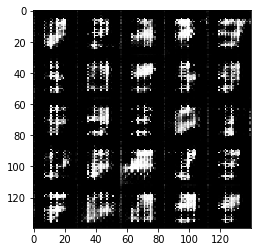

Epoch 1/2... Batch 110... Discriminator Loss: 0.5616... Generator Loss: 2.6442
Epoch 1/2... Batch 120... Discriminator Loss: 1.4415... Generator Loss: 1.0480
Epoch 1/2... Batch 130... Discriminator Loss: 1.2716... Generator Loss: 2.0193
Epoch 1/2... Batch 140... Discriminator Loss: 4.2364... Generator Loss: 0.0670
Epoch 1/2... Batch 150... Discriminator Loss: 3.5374... Generator Loss: 4.2868
Epoch 1/2... Batch 160... Discriminator Loss: 1.7314... Generator Loss: 3.9843
Epoch 1/2... Batch 170... Discriminator Loss: 1.4008... Generator Loss: 0.6427
Epoch 1/2... Batch 180... Discriminator Loss: 0.8271... Generator Loss: 1.6079
Epoch 1/2... Batch 190... Discriminator Loss: 1.2690... Generator Loss: 2.0028
Epoch 1/2... Batch 200... Discriminator Loss: 1.1701... Generator Loss: 0.9946


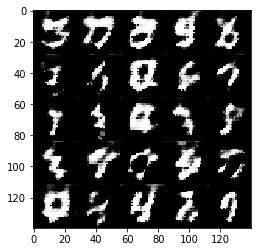

Epoch 1/2... Batch 210... Discriminator Loss: 0.8593... Generator Loss: 1.2460
Epoch 1/2... Batch 220... Discriminator Loss: 1.3867... Generator Loss: 0.5892
Epoch 1/2... Batch 230... Discriminator Loss: 1.3135... Generator Loss: 0.9647
Epoch 1/2... Batch 240... Discriminator Loss: 1.5303... Generator Loss: 0.5389
Epoch 1/2... Batch 250... Discriminator Loss: 1.3564... Generator Loss: 1.3401
Epoch 1/2... Batch 260... Discriminator Loss: 1.0456... Generator Loss: 1.3146
Epoch 1/2... Batch 270... Discriminator Loss: 1.4230... Generator Loss: 0.6680
Epoch 1/2... Batch 280... Discriminator Loss: 1.7714... Generator Loss: 1.2250
Epoch 1/2... Batch 290... Discriminator Loss: 0.9899... Generator Loss: 1.4496
Epoch 1/2... Batch 300... Discriminator Loss: 1.7463... Generator Loss: 0.9099


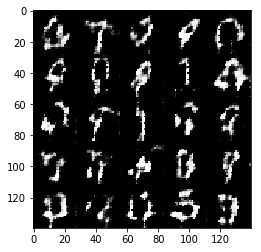

Epoch 1/2... Batch 310... Discriminator Loss: 1.9987... Generator Loss: 0.2667
Epoch 1/2... Batch 320... Discriminator Loss: 1.1933... Generator Loss: 1.0297
Epoch 1/2... Batch 330... Discriminator Loss: 1.1615... Generator Loss: 1.1255
Epoch 1/2... Batch 340... Discriminator Loss: 1.4582... Generator Loss: 0.4919
Epoch 1/2... Batch 350... Discriminator Loss: 1.2233... Generator Loss: 0.6966
Epoch 1/2... Batch 360... Discriminator Loss: 1.0710... Generator Loss: 1.1995
Epoch 1/2... Batch 370... Discriminator Loss: 1.2190... Generator Loss: 0.7990
Epoch 1/2... Batch 380... Discriminator Loss: 1.4844... Generator Loss: 0.4926
Epoch 1/2... Batch 390... Discriminator Loss: 1.3124... Generator Loss: 1.1735
Epoch 1/2... Batch 400... Discriminator Loss: 1.4859... Generator Loss: 0.6717


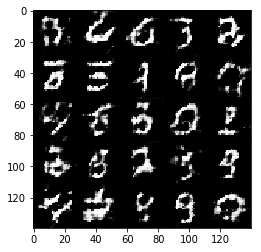

Epoch 1/2... Batch 410... Discriminator Loss: 1.1192... Generator Loss: 1.7012
Epoch 1/2... Batch 420... Discriminator Loss: 1.1981... Generator Loss: 1.0109
Epoch 1/2... Batch 430... Discriminator Loss: 2.7712... Generator Loss: 3.6539
Epoch 1/2... Batch 440... Discriminator Loss: 1.1791... Generator Loss: 1.0063
Epoch 1/2... Batch 450... Discriminator Loss: 1.1994... Generator Loss: 1.8113
Epoch 1/2... Batch 460... Discriminator Loss: 1.2252... Generator Loss: 1.3493
Epoch 1/2... Batch 470... Discriminator Loss: 1.2621... Generator Loss: 1.7449
Epoch 1/2... Batch 480... Discriminator Loss: 1.2503... Generator Loss: 0.6694
Epoch 1/2... Batch 490... Discriminator Loss: 1.4538... Generator Loss: 1.4284
Epoch 1/2... Batch 500... Discriminator Loss: 1.3558... Generator Loss: 0.5825


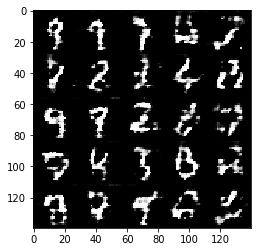

Epoch 1/2... Batch 510... Discriminator Loss: 0.9261... Generator Loss: 1.2236
Epoch 1/2... Batch 520... Discriminator Loss: 1.2577... Generator Loss: 0.9494
Epoch 1/2... Batch 530... Discriminator Loss: 1.3535... Generator Loss: 0.8329
Epoch 1/2... Batch 540... Discriminator Loss: 1.0696... Generator Loss: 0.9751
Epoch 1/2... Batch 550... Discriminator Loss: 1.0134... Generator Loss: 1.2055
Epoch 1/2... Batch 560... Discriminator Loss: 1.1929... Generator Loss: 0.8451
Epoch 1/2... Batch 570... Discriminator Loss: 1.2663... Generator Loss: 0.7976
Epoch 1/2... Batch 580... Discriminator Loss: 1.1631... Generator Loss: 1.1632
Epoch 1/2... Batch 590... Discriminator Loss: 1.0459... Generator Loss: 0.9545
Epoch 1/2... Batch 600... Discriminator Loss: 1.3093... Generator Loss: 0.6889


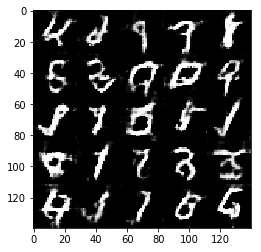

Epoch 1/2... Batch 610... Discriminator Loss: 1.1907... Generator Loss: 0.6707
Epoch 1/2... Batch 620... Discriminator Loss: 1.2792... Generator Loss: 1.7829
Epoch 1/2... Batch 630... Discriminator Loss: 1.1704... Generator Loss: 0.7668
Epoch 1/2... Batch 640... Discriminator Loss: 1.2360... Generator Loss: 0.6585
Epoch 1/2... Batch 650... Discriminator Loss: 1.2437... Generator Loss: 0.8339
Epoch 1/2... Batch 660... Discriminator Loss: 1.7029... Generator Loss: 0.3996
Epoch 1/2... Batch 670... Discriminator Loss: 1.2549... Generator Loss: 0.7615
Epoch 1/2... Batch 680... Discriminator Loss: 1.5104... Generator Loss: 0.6553
Epoch 1/2... Batch 690... Discriminator Loss: 1.2982... Generator Loss: 0.6506
Epoch 1/2... Batch 700... Discriminator Loss: 1.2237... Generator Loss: 0.9910


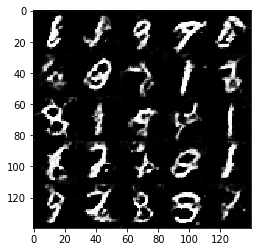

Epoch 1/2... Batch 710... Discriminator Loss: 1.5275... Generator Loss: 0.5111
Epoch 1/2... Batch 720... Discriminator Loss: 1.1848... Generator Loss: 0.7423
Epoch 1/2... Batch 730... Discriminator Loss: 1.3675... Generator Loss: 0.6465
Epoch 1/2... Batch 740... Discriminator Loss: 1.6934... Generator Loss: 0.4142
Epoch 1/2... Batch 750... Discriminator Loss: 1.0250... Generator Loss: 0.9643
Epoch 1/2... Batch 760... Discriminator Loss: 1.1375... Generator Loss: 0.8281
Epoch 1/2... Batch 770... Discriminator Loss: 1.0684... Generator Loss: 1.0841
Epoch 1/2... Batch 780... Discriminator Loss: 1.3254... Generator Loss: 1.3081
Epoch 1/2... Batch 790... Discriminator Loss: 1.0964... Generator Loss: 1.7505
Epoch 1/2... Batch 800... Discriminator Loss: 1.1807... Generator Loss: 1.8069


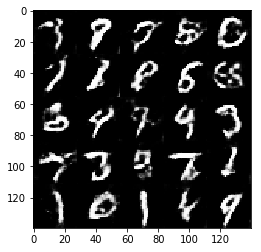

Epoch 1/2... Batch 810... Discriminator Loss: 1.2969... Generator Loss: 1.4345
Epoch 1/2... Batch 820... Discriminator Loss: 1.0020... Generator Loss: 1.0615
Epoch 1/2... Batch 830... Discriminator Loss: 1.1279... Generator Loss: 1.0407
Epoch 1/2... Batch 840... Discriminator Loss: 1.3281... Generator Loss: 0.6348
Epoch 1/2... Batch 850... Discriminator Loss: 1.1927... Generator Loss: 0.9834
Epoch 1/2... Batch 860... Discriminator Loss: 1.3087... Generator Loss: 1.0664
Epoch 1/2... Batch 870... Discriminator Loss: 1.0269... Generator Loss: 1.2909
Epoch 1/2... Batch 880... Discriminator Loss: 1.8701... Generator Loss: 0.2927
Epoch 1/2... Batch 890... Discriminator Loss: 1.4770... Generator Loss: 0.5633
Epoch 1/2... Batch 900... Discriminator Loss: 1.4739... Generator Loss: 0.4956


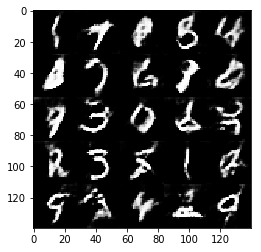

Epoch 1/2... Batch 910... Discriminator Loss: 1.2930... Generator Loss: 0.6938
Epoch 1/2... Batch 920... Discriminator Loss: 1.4750... Generator Loss: 0.5046
Epoch 1/2... Batch 930... Discriminator Loss: 1.2351... Generator Loss: 0.8467
Epoch 1/2... Batch 940... Discriminator Loss: 1.2568... Generator Loss: 0.6477
Epoch 1/2... Batch 950... Discriminator Loss: 1.3433... Generator Loss: 0.7682
Epoch 1/2... Batch 960... Discriminator Loss: 1.1710... Generator Loss: 2.0058
Epoch 1/2... Batch 970... Discriminator Loss: 1.6073... Generator Loss: 0.4860
Epoch 1/2... Batch 980... Discriminator Loss: 1.1632... Generator Loss: 1.1899
Epoch 1/2... Batch 990... Discriminator Loss: 1.3079... Generator Loss: 0.7392
Epoch 1/2... Batch 1000... Discriminator Loss: 1.2656... Generator Loss: 2.1715


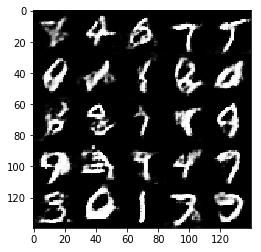

Epoch 1/2... Batch 1010... Discriminator Loss: 1.1174... Generator Loss: 0.8649
Epoch 1/2... Batch 1020... Discriminator Loss: 1.4909... Generator Loss: 0.5113
Epoch 1/2... Batch 1030... Discriminator Loss: 1.7385... Generator Loss: 0.3674
Epoch 1/2... Batch 1040... Discriminator Loss: 1.1822... Generator Loss: 0.7232
Epoch 1/2... Batch 1050... Discriminator Loss: 1.3065... Generator Loss: 2.4329
Epoch 1/2... Batch 1060... Discriminator Loss: 1.4597... Generator Loss: 0.5203
Epoch 1/2... Batch 1070... Discriminator Loss: 1.5797... Generator Loss: 0.4591
Epoch 1/2... Batch 1080... Discriminator Loss: 1.2453... Generator Loss: 0.6825
Epoch 1/2... Batch 1090... Discriminator Loss: 1.0654... Generator Loss: 1.4582
Epoch 1/2... Batch 1100... Discriminator Loss: 1.0734... Generator Loss: 1.1732


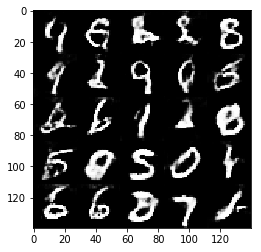

Epoch 1/2... Batch 1110... Discriminator Loss: 1.6390... Generator Loss: 2.2741
Epoch 1/2... Batch 1120... Discriminator Loss: 0.8524... Generator Loss: 1.3840
Epoch 1/2... Batch 1130... Discriminator Loss: 1.1090... Generator Loss: 1.6740
Epoch 1/2... Batch 1140... Discriminator Loss: 1.4431... Generator Loss: 0.5066
Epoch 1/2... Batch 1150... Discriminator Loss: 0.9719... Generator Loss: 1.3005
Epoch 1/2... Batch 1160... Discriminator Loss: 1.0946... Generator Loss: 1.1085
Epoch 1/2... Batch 1170... Discriminator Loss: 1.1808... Generator Loss: 1.1246
Epoch 1/2... Batch 1180... Discriminator Loss: 1.3735... Generator Loss: 0.6351
Epoch 1/2... Batch 1190... Discriminator Loss: 1.5036... Generator Loss: 0.4917
Epoch 1/2... Batch 1200... Discriminator Loss: 1.3931... Generator Loss: 0.5522


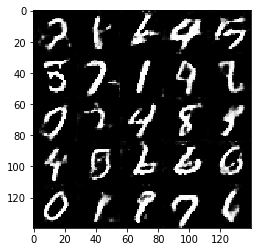

Epoch 1/2... Batch 1210... Discriminator Loss: 1.7287... Generator Loss: 0.5726
Epoch 1/2... Batch 1220... Discriminator Loss: 0.9730... Generator Loss: 1.1878
Epoch 1/2... Batch 1230... Discriminator Loss: 0.9182... Generator Loss: 2.2928
Epoch 1/2... Batch 1240... Discriminator Loss: 1.0859... Generator Loss: 1.0648
Epoch 1/2... Batch 1250... Discriminator Loss: 1.2996... Generator Loss: 0.6083
Epoch 1/2... Batch 1260... Discriminator Loss: 1.0220... Generator Loss: 1.0021
Epoch 1/2... Batch 1270... Discriminator Loss: 0.9557... Generator Loss: 1.6006
Epoch 1/2... Batch 1280... Discriminator Loss: 1.3859... Generator Loss: 0.6247
Epoch 1/2... Batch 1290... Discriminator Loss: 0.9120... Generator Loss: 1.5244
Epoch 1/2... Batch 1300... Discriminator Loss: 0.9771... Generator Loss: 1.3883


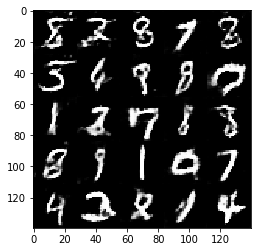

Epoch 1/2... Batch 1310... Discriminator Loss: 0.8082... Generator Loss: 1.4435
Epoch 1/2... Batch 1320... Discriminator Loss: 0.9965... Generator Loss: 1.4063
Epoch 1/2... Batch 1330... Discriminator Loss: 1.1788... Generator Loss: 1.9650
Epoch 1/2... Batch 1340... Discriminator Loss: 1.1035... Generator Loss: 0.9760
Epoch 1/2... Batch 1350... Discriminator Loss: 0.8771... Generator Loss: 1.8689
Epoch 1/2... Batch 1360... Discriminator Loss: 1.0178... Generator Loss: 1.1634
Epoch 1/2... Batch 1370... Discriminator Loss: 1.8999... Generator Loss: 0.3377
Epoch 1/2... Batch 1380... Discriminator Loss: 1.1603... Generator Loss: 0.7573
Epoch 1/2... Batch 1390... Discriminator Loss: 1.1892... Generator Loss: 0.7123
Epoch 1/2... Batch 1400... Discriminator Loss: 1.2371... Generator Loss: 0.7822


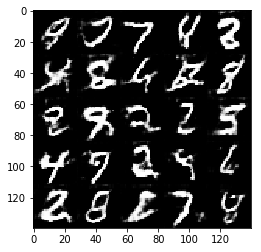

Epoch 1/2... Batch 1410... Discriminator Loss: 1.0016... Generator Loss: 1.1289
Epoch 1/2... Batch 1420... Discriminator Loss: 1.3289... Generator Loss: 0.6501
Epoch 1/2... Batch 1430... Discriminator Loss: 0.9636... Generator Loss: 1.1031
Epoch 1/2... Batch 1440... Discriminator Loss: 1.0722... Generator Loss: 0.7466
Epoch 1/2... Batch 1450... Discriminator Loss: 0.8992... Generator Loss: 1.3905
Epoch 1/2... Batch 1460... Discriminator Loss: 1.0524... Generator Loss: 0.8854
Epoch 1/2... Batch 1470... Discriminator Loss: 0.9747... Generator Loss: 2.0497
Epoch 1/2... Batch 1480... Discriminator Loss: 1.1182... Generator Loss: 0.9303
Epoch 1/2... Batch 1490... Discriminator Loss: 0.7291... Generator Loss: 2.0095
Epoch 1/2... Batch 1500... Discriminator Loss: 0.9706... Generator Loss: 1.6830


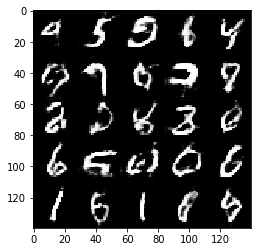

Epoch 1/2... Batch 1510... Discriminator Loss: 0.7939... Generator Loss: 1.3357
Epoch 1/2... Batch 1520... Discriminator Loss: 0.7785... Generator Loss: 1.4948
Epoch 1/2... Batch 1530... Discriminator Loss: 1.8077... Generator Loss: 0.3631
Epoch 1/2... Batch 1540... Discriminator Loss: 0.8169... Generator Loss: 1.2568
Epoch 1/2... Batch 1550... Discriminator Loss: 0.9357... Generator Loss: 1.4504
Epoch 1/2... Batch 1560... Discriminator Loss: 0.9030... Generator Loss: 0.9322
Epoch 1/2... Batch 1570... Discriminator Loss: 2.8940... Generator Loss: 0.1745
Epoch 1/2... Batch 1580... Discriminator Loss: 1.6198... Generator Loss: 0.4336
Epoch 1/2... Batch 1590... Discriminator Loss: 1.4026... Generator Loss: 0.5393
Epoch 1/2... Batch 1600... Discriminator Loss: 0.9853... Generator Loss: 0.9443


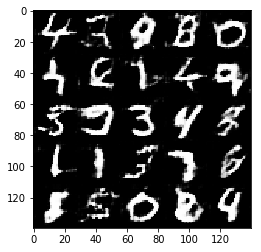

Epoch 1/2... Batch 1610... Discriminator Loss: 1.1563... Generator Loss: 0.9419
Epoch 1/2... Batch 1620... Discriminator Loss: 0.9513... Generator Loss: 1.0217
Epoch 1/2... Batch 1630... Discriminator Loss: 0.8225... Generator Loss: 1.5294
Epoch 1/2... Batch 1640... Discriminator Loss: 0.9658... Generator Loss: 1.7100
Epoch 1/2... Batch 1650... Discriminator Loss: 1.1191... Generator Loss: 0.8211
Epoch 1/2... Batch 1660... Discriminator Loss: 0.8132... Generator Loss: 1.3754
Epoch 1/2... Batch 1670... Discriminator Loss: 0.7601... Generator Loss: 2.2541
Epoch 1/2... Batch 1680... Discriminator Loss: 1.3606... Generator Loss: 0.6206
Epoch 1/2... Batch 1690... Discriminator Loss: 1.7146... Generator Loss: 0.3625
Epoch 1/2... Batch 1700... Discriminator Loss: 1.3020... Generator Loss: 1.2394


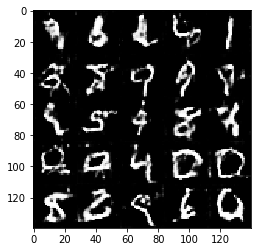

Epoch 1/2... Batch 1710... Discriminator Loss: 0.8908... Generator Loss: 1.3810
Epoch 1/2... Batch 1720... Discriminator Loss: 1.6827... Generator Loss: 0.4582
Epoch 1/2... Batch 1730... Discriminator Loss: 1.6962... Generator Loss: 0.3766
Epoch 1/2... Batch 1740... Discriminator Loss: 0.9549... Generator Loss: 1.0558
Epoch 1/2... Batch 1750... Discriminator Loss: 0.8529... Generator Loss: 1.3358
Epoch 1/2... Batch 1760... Discriminator Loss: 2.1011... Generator Loss: 0.2888
Epoch 1/2... Batch 1770... Discriminator Loss: 1.1052... Generator Loss: 1.8299
Epoch 1/2... Batch 1780... Discriminator Loss: 0.8744... Generator Loss: 2.7044
Epoch 1/2... Batch 1790... Discriminator Loss: 1.0857... Generator Loss: 0.7608
Epoch 1/2... Batch 1800... Discriminator Loss: 1.3762... Generator Loss: 2.7950


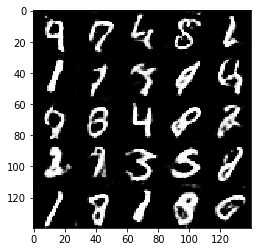

Epoch 1/2... Batch 1810... Discriminator Loss: 1.8529... Generator Loss: 0.3326
Epoch 1/2... Batch 1820... Discriminator Loss: 1.5658... Generator Loss: 0.4808
Epoch 1/2... Batch 1830... Discriminator Loss: 0.8817... Generator Loss: 1.6600
Epoch 1/2... Batch 1840... Discriminator Loss: 0.8990... Generator Loss: 1.0457
Epoch 1/2... Batch 1850... Discriminator Loss: 0.9614... Generator Loss: 0.9828
Epoch 1/2... Batch 1860... Discriminator Loss: 0.7818... Generator Loss: 1.4966
Epoch 1/2... Batch 1870... Discriminator Loss: 0.7170... Generator Loss: 2.9605
Epoch 2/2... Batch 10... Discriminator Loss: 0.9572... Generator Loss: 1.0713
Epoch 2/2... Batch 20... Discriminator Loss: 0.8228... Generator Loss: 1.3723
Epoch 2/2... Batch 30... Discriminator Loss: 1.3373... Generator Loss: 0.6052
Epoch 2/2... Batch 40... Discriminator Loss: 0.5186... Generator Loss: 2.4431
Epoch 2/2... Batch 50... Discriminator Loss: 1.0644... Generator Loss: 0.8681
Epoch 2/2... Batch 60... Discriminator Loss: 1.204

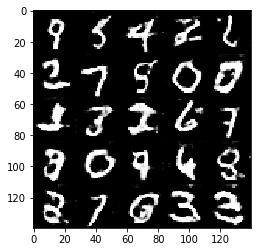

Epoch 2/2... Batch 110... Discriminator Loss: 2.1681... Generator Loss: 0.3802
Epoch 2/2... Batch 120... Discriminator Loss: 0.7756... Generator Loss: 1.5928
Epoch 2/2... Batch 130... Discriminator Loss: 1.5952... Generator Loss: 0.5297
Epoch 2/2... Batch 140... Discriminator Loss: 0.6166... Generator Loss: 2.0356
Epoch 2/2... Batch 150... Discriminator Loss: 3.0823... Generator Loss: 0.1894
Epoch 2/2... Batch 160... Discriminator Loss: 1.0619... Generator Loss: 0.9225
Epoch 2/2... Batch 170... Discriminator Loss: 0.6665... Generator Loss: 1.7221
Epoch 2/2... Batch 180... Discriminator Loss: 1.4930... Generator Loss: 0.5284
Epoch 2/2... Batch 190... Discriminator Loss: 1.1268... Generator Loss: 0.7759
Epoch 2/2... Batch 200... Discriminator Loss: 0.8958... Generator Loss: 1.1782


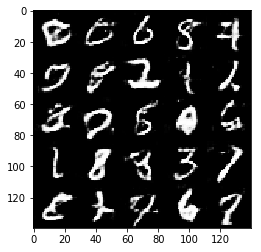

Epoch 2/2... Batch 210... Discriminator Loss: 0.5013... Generator Loss: 2.6298
Epoch 2/2... Batch 220... Discriminator Loss: 0.9882... Generator Loss: 2.1083
Epoch 2/2... Batch 230... Discriminator Loss: 1.6321... Generator Loss: 0.4505
Epoch 2/2... Batch 240... Discriminator Loss: 0.7866... Generator Loss: 1.4937
Epoch 2/2... Batch 250... Discriminator Loss: 1.1689... Generator Loss: 1.1729
Epoch 2/2... Batch 260... Discriminator Loss: 1.2574... Generator Loss: 0.6824
Epoch 2/2... Batch 270... Discriminator Loss: 1.0943... Generator Loss: 0.9132
Epoch 2/2... Batch 280... Discriminator Loss: 0.9420... Generator Loss: 1.0452
Epoch 2/2... Batch 290... Discriminator Loss: 1.8053... Generator Loss: 0.3362
Epoch 2/2... Batch 300... Discriminator Loss: 0.7460... Generator Loss: 1.6789


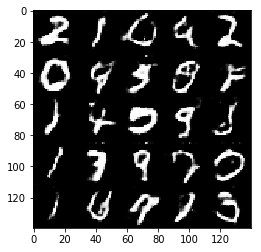

Epoch 2/2... Batch 310... Discriminator Loss: 1.0029... Generator Loss: 0.9114
Epoch 2/2... Batch 320... Discriminator Loss: 0.6155... Generator Loss: 1.7865
Epoch 2/2... Batch 330... Discriminator Loss: 0.8602... Generator Loss: 1.2306
Epoch 2/2... Batch 340... Discriminator Loss: 0.9475... Generator Loss: 1.4477
Epoch 2/2... Batch 350... Discriminator Loss: 1.0089... Generator Loss: 0.9773
Epoch 2/2... Batch 360... Discriminator Loss: 1.1188... Generator Loss: 0.8019
Epoch 2/2... Batch 370... Discriminator Loss: 1.3550... Generator Loss: 0.6476
Epoch 2/2... Batch 380... Discriminator Loss: 1.0078... Generator Loss: 0.9580
Epoch 2/2... Batch 390... Discriminator Loss: 0.6572... Generator Loss: 2.0897
Epoch 2/2... Batch 400... Discriminator Loss: 0.7578... Generator Loss: 1.8312


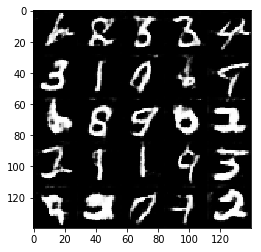

Epoch 2/2... Batch 410... Discriminator Loss: 1.0756... Generator Loss: 0.9688
Epoch 2/2... Batch 420... Discriminator Loss: 0.8092... Generator Loss: 1.2627
Epoch 2/2... Batch 430... Discriminator Loss: 0.7909... Generator Loss: 1.7623
Epoch 2/2... Batch 440... Discriminator Loss: 0.9746... Generator Loss: 1.0979
Epoch 2/2... Batch 450... Discriminator Loss: 0.7391... Generator Loss: 1.3894
Epoch 2/2... Batch 460... Discriminator Loss: 0.8760... Generator Loss: 1.0751
Epoch 2/2... Batch 470... Discriminator Loss: 0.9898... Generator Loss: 1.0285
Epoch 2/2... Batch 480... Discriminator Loss: 0.9824... Generator Loss: 1.1684
Epoch 2/2... Batch 490... Discriminator Loss: 0.9371... Generator Loss: 1.2525
Epoch 2/2... Batch 500... Discriminator Loss: 0.7852... Generator Loss: 1.5018


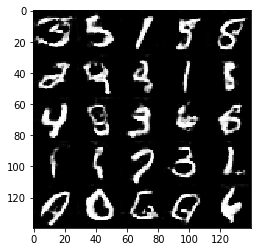

Epoch 2/2... Batch 510... Discriminator Loss: 0.7661... Generator Loss: 2.4320
Epoch 2/2... Batch 520... Discriminator Loss: 0.7931... Generator Loss: 2.4653
Epoch 2/2... Batch 530... Discriminator Loss: 1.7878... Generator Loss: 0.3811
Epoch 2/2... Batch 540... Discriminator Loss: 1.1796... Generator Loss: 0.7334
Epoch 2/2... Batch 550... Discriminator Loss: 1.1512... Generator Loss: 1.1096
Epoch 2/2... Batch 560... Discriminator Loss: 0.7239... Generator Loss: 1.6399
Epoch 2/2... Batch 570... Discriminator Loss: 1.1320... Generator Loss: 0.8141
Epoch 2/2... Batch 580... Discriminator Loss: 0.8402... Generator Loss: 1.2487
Epoch 2/2... Batch 590... Discriminator Loss: 0.5892... Generator Loss: 2.1833
Epoch 2/2... Batch 600... Discriminator Loss: 1.2804... Generator Loss: 3.0808


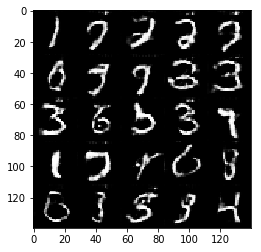

Epoch 2/2... Batch 610... Discriminator Loss: 1.0776... Generator Loss: 0.9295
Epoch 2/2... Batch 620... Discriminator Loss: 3.5816... Generator Loss: 0.0875
Epoch 2/2... Batch 630... Discriminator Loss: 1.4205... Generator Loss: 0.6748
Epoch 2/2... Batch 640... Discriminator Loss: 0.8635... Generator Loss: 2.7197
Epoch 2/2... Batch 650... Discriminator Loss: 0.7341... Generator Loss: 1.8537
Epoch 2/2... Batch 660... Discriminator Loss: 0.7038... Generator Loss: 2.7924
Epoch 2/2... Batch 670... Discriminator Loss: 0.9593... Generator Loss: 1.2763
Epoch 2/2... Batch 680... Discriminator Loss: 2.1643... Generator Loss: 0.2893
Epoch 2/2... Batch 690... Discriminator Loss: 1.7340... Generator Loss: 0.4434
Epoch 2/2... Batch 700... Discriminator Loss: 1.0997... Generator Loss: 0.8120


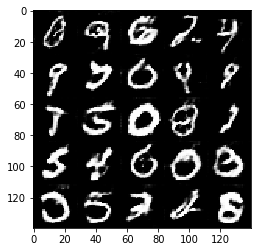

Epoch 2/2... Batch 710... Discriminator Loss: 1.3546... Generator Loss: 0.6421
Epoch 2/2... Batch 720... Discriminator Loss: 0.6810... Generator Loss: 2.7958
Epoch 2/2... Batch 730... Discriminator Loss: 0.8357... Generator Loss: 1.3074
Epoch 2/2... Batch 740... Discriminator Loss: 0.9764... Generator Loss: 2.2405
Epoch 2/2... Batch 750... Discriminator Loss: 1.4038... Generator Loss: 4.3075
Epoch 2/2... Batch 760... Discriminator Loss: 0.6450... Generator Loss: 2.3421
Epoch 2/2... Batch 770... Discriminator Loss: 2.0208... Generator Loss: 0.3232
Epoch 2/2... Batch 780... Discriminator Loss: 0.9082... Generator Loss: 2.2968
Epoch 2/2... Batch 790... Discriminator Loss: 0.7008... Generator Loss: 1.4684
Epoch 2/2... Batch 800... Discriminator Loss: 1.1442... Generator Loss: 0.8540


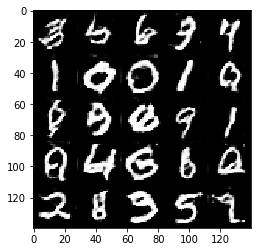

Epoch 2/2... Batch 810... Discriminator Loss: 1.4712... Generator Loss: 0.5202
Epoch 2/2... Batch 820... Discriminator Loss: 0.7654... Generator Loss: 1.3181
Epoch 2/2... Batch 830... Discriminator Loss: 1.3142... Generator Loss: 0.7432
Epoch 2/2... Batch 840... Discriminator Loss: 0.8277... Generator Loss: 1.6383
Epoch 2/2... Batch 850... Discriminator Loss: 0.6284... Generator Loss: 1.6174
Epoch 2/2... Batch 860... Discriminator Loss: 2.0927... Generator Loss: 0.3471
Epoch 2/2... Batch 870... Discriminator Loss: 1.1732... Generator Loss: 0.6969
Epoch 2/2... Batch 880... Discriminator Loss: 1.1037... Generator Loss: 0.8261
Epoch 2/2... Batch 890... Discriminator Loss: 0.7643... Generator Loss: 1.3396
Epoch 2/2... Batch 900... Discriminator Loss: 1.7461... Generator Loss: 0.5440


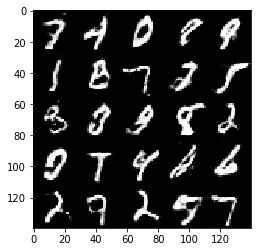

Epoch 2/2... Batch 910... Discriminator Loss: 0.7444... Generator Loss: 1.4592
Epoch 2/2... Batch 920... Discriminator Loss: 0.8760... Generator Loss: 2.0359
Epoch 2/2... Batch 930... Discriminator Loss: 2.4135... Generator Loss: 0.2408
Epoch 2/2... Batch 940... Discriminator Loss: 0.9925... Generator Loss: 1.1839
Epoch 2/2... Batch 950... Discriminator Loss: 1.0335... Generator Loss: 0.9434
Epoch 2/2... Batch 960... Discriminator Loss: 1.1929... Generator Loss: 0.9674
Epoch 2/2... Batch 970... Discriminator Loss: 0.6373... Generator Loss: 1.6401
Epoch 2/2... Batch 980... Discriminator Loss: 0.7263... Generator Loss: 1.6893
Epoch 2/2... Batch 990... Discriminator Loss: 0.7572... Generator Loss: 1.7305
Epoch 2/2... Batch 1000... Discriminator Loss: 0.7408... Generator Loss: 2.3119


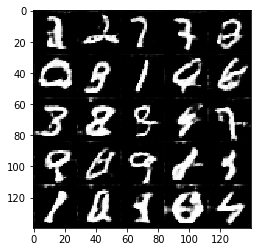

Epoch 2/2... Batch 1010... Discriminator Loss: 0.9171... Generator Loss: 1.0470
Epoch 2/2... Batch 1020... Discriminator Loss: 0.8584... Generator Loss: 1.1798
Epoch 2/2... Batch 1030... Discriminator Loss: 0.6799... Generator Loss: 1.8785
Epoch 2/2... Batch 1040... Discriminator Loss: 1.8848... Generator Loss: 0.5483
Epoch 2/2... Batch 1050... Discriminator Loss: 1.0143... Generator Loss: 3.8200
Epoch 2/2... Batch 1060... Discriminator Loss: 1.4144... Generator Loss: 0.6261
Epoch 2/2... Batch 1070... Discriminator Loss: 0.7155... Generator Loss: 1.5821
Epoch 2/2... Batch 1080... Discriminator Loss: 0.8202... Generator Loss: 1.3402
Epoch 2/2... Batch 1090... Discriminator Loss: 0.9990... Generator Loss: 1.1292
Epoch 2/2... Batch 1100... Discriminator Loss: 0.5797... Generator Loss: 2.3610


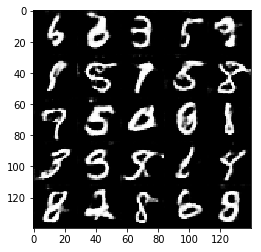

Epoch 2/2... Batch 1110... Discriminator Loss: 1.7566... Generator Loss: 4.7932
Epoch 2/2... Batch 1120... Discriminator Loss: 2.1568... Generator Loss: 4.9594
Epoch 2/2... Batch 1130... Discriminator Loss: 1.1279... Generator Loss: 2.0652
Epoch 2/2... Batch 1140... Discriminator Loss: 1.0416... Generator Loss: 0.9323
Epoch 2/2... Batch 1150... Discriminator Loss: 1.2635... Generator Loss: 0.8756
Epoch 2/2... Batch 1160... Discriminator Loss: 0.8874... Generator Loss: 1.2351
Epoch 2/2... Batch 1170... Discriminator Loss: 1.7818... Generator Loss: 0.5145
Epoch 2/2... Batch 1180... Discriminator Loss: 0.7118... Generator Loss: 2.2682
Epoch 2/2... Batch 1190... Discriminator Loss: 1.3014... Generator Loss: 3.8968
Epoch 2/2... Batch 1200... Discriminator Loss: 0.8470... Generator Loss: 1.3193


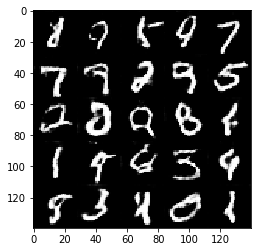

Epoch 2/2... Batch 1210... Discriminator Loss: 1.6669... Generator Loss: 0.5358
Epoch 2/2... Batch 1220... Discriminator Loss: 1.1040... Generator Loss: 0.8699
Epoch 2/2... Batch 1230... Discriminator Loss: 0.5454... Generator Loss: 3.3401
Epoch 2/2... Batch 1240... Discriminator Loss: 0.7091... Generator Loss: 1.6166
Epoch 2/2... Batch 1250... Discriminator Loss: 2.3395... Generator Loss: 0.2731
Epoch 2/2... Batch 1260... Discriminator Loss: 2.6067... Generator Loss: 0.1827
Epoch 2/2... Batch 1270... Discriminator Loss: 1.2589... Generator Loss: 0.8200
Epoch 2/2... Batch 1280... Discriminator Loss: 1.1987... Generator Loss: 0.8351
Epoch 2/2... Batch 1290... Discriminator Loss: 1.2963... Generator Loss: 0.7455
Epoch 2/2... Batch 1300... Discriminator Loss: 0.7398... Generator Loss: 2.2081


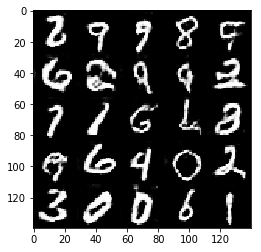

Epoch 2/2... Batch 1310... Discriminator Loss: 0.8346... Generator Loss: 1.2030
Epoch 2/2... Batch 1320... Discriminator Loss: 1.2533... Generator Loss: 0.7646
Epoch 2/2... Batch 1330... Discriminator Loss: 0.6582... Generator Loss: 1.7056
Epoch 2/2... Batch 1340... Discriminator Loss: 0.8595... Generator Loss: 1.3666
Epoch 2/2... Batch 1350... Discriminator Loss: 0.7320... Generator Loss: 1.6579
Epoch 2/2... Batch 1360... Discriminator Loss: 1.3523... Generator Loss: 0.6226
Epoch 2/2... Batch 1370... Discriminator Loss: 3.3050... Generator Loss: 0.1093
Epoch 2/2... Batch 1380... Discriminator Loss: 0.7021... Generator Loss: 1.8143
Epoch 2/2... Batch 1390... Discriminator Loss: 0.9826... Generator Loss: 0.9499
Epoch 2/2... Batch 1400... Discriminator Loss: 0.7553... Generator Loss: 1.3830


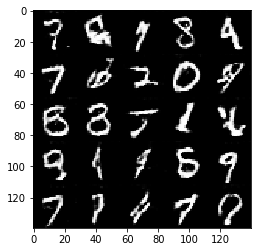

Epoch 2/2... Batch 1410... Discriminator Loss: 2.9545... Generator Loss: 0.1562
Epoch 2/2... Batch 1420... Discriminator Loss: 0.7685... Generator Loss: 1.4379
Epoch 2/2... Batch 1430... Discriminator Loss: 1.1229... Generator Loss: 0.8259
Epoch 2/2... Batch 1440... Discriminator Loss: 2.0262... Generator Loss: 0.5113
Epoch 2/2... Batch 1450... Discriminator Loss: 1.7147... Generator Loss: 0.4714
Epoch 2/2... Batch 1460... Discriminator Loss: 0.9788... Generator Loss: 1.0457
Epoch 2/2... Batch 1470... Discriminator Loss: 0.8854... Generator Loss: 1.1958
Epoch 2/2... Batch 1480... Discriminator Loss: 0.6939... Generator Loss: 1.7284
Epoch 2/2... Batch 1490... Discriminator Loss: 0.6639... Generator Loss: 1.6523
Epoch 2/2... Batch 1500... Discriminator Loss: 0.8697... Generator Loss: 2.4246


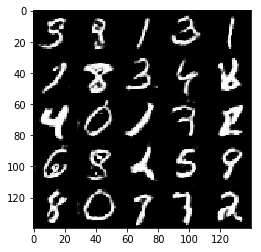

Epoch 2/2... Batch 1510... Discriminator Loss: 1.1320... Generator Loss: 0.8506
Epoch 2/2... Batch 1520... Discriminator Loss: 2.2510... Generator Loss: 0.2894
Epoch 2/2... Batch 1530... Discriminator Loss: 1.3683... Generator Loss: 0.8765
Epoch 2/2... Batch 1540... Discriminator Loss: 1.6283... Generator Loss: 0.5983
Epoch 2/2... Batch 1550... Discriminator Loss: 1.7506... Generator Loss: 0.5869
Epoch 2/2... Batch 1560... Discriminator Loss: 1.7297... Generator Loss: 0.4001
Epoch 2/2... Batch 1570... Discriminator Loss: 1.7446... Generator Loss: 0.4138
Epoch 2/2... Batch 1580... Discriminator Loss: 0.9534... Generator Loss: 1.1582
Epoch 2/2... Batch 1590... Discriminator Loss: 1.1330... Generator Loss: 0.8490
Epoch 2/2... Batch 1600... Discriminator Loss: 0.9403... Generator Loss: 1.0733


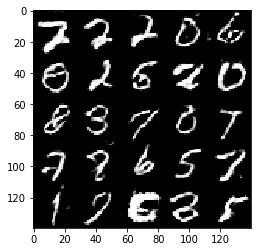

Epoch 2/2... Batch 1610... Discriminator Loss: 2.1906... Generator Loss: 0.2757
Epoch 2/2... Batch 1620... Discriminator Loss: 0.9386... Generator Loss: 4.1602
Epoch 2/2... Batch 1630... Discriminator Loss: 0.8205... Generator Loss: 1.3117
Epoch 2/2... Batch 1640... Discriminator Loss: 0.9425... Generator Loss: 1.0370
Epoch 2/2... Batch 1650... Discriminator Loss: 0.6760... Generator Loss: 2.7489
Epoch 2/2... Batch 1660... Discriminator Loss: 0.6849... Generator Loss: 1.9656
Epoch 2/2... Batch 1670... Discriminator Loss: 0.7130... Generator Loss: 1.6038
Epoch 2/2... Batch 1680... Discriminator Loss: 0.9257... Generator Loss: 2.6006
Epoch 2/2... Batch 1690... Discriminator Loss: 1.8863... Generator Loss: 0.3843
Epoch 2/2... Batch 1700... Discriminator Loss: 1.1355... Generator Loss: 0.8028


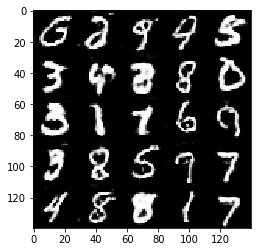

Epoch 2/2... Batch 1710... Discriminator Loss: 1.7686... Generator Loss: 4.7757
Epoch 2/2... Batch 1720... Discriminator Loss: 0.7434... Generator Loss: 1.6462
Epoch 2/2... Batch 1730... Discriminator Loss: 1.0494... Generator Loss: 0.8864
Epoch 2/2... Batch 1740... Discriminator Loss: 0.9376... Generator Loss: 1.1612
Epoch 2/2... Batch 1750... Discriminator Loss: 1.2622... Generator Loss: 0.8044
Epoch 2/2... Batch 1760... Discriminator Loss: 0.7206... Generator Loss: 1.5492
Epoch 2/2... Batch 1770... Discriminator Loss: 0.6798... Generator Loss: 1.6313
Epoch 2/2... Batch 1780... Discriminator Loss: 0.8478... Generator Loss: 1.3102
Epoch 2/2... Batch 1790... Discriminator Loss: 1.2314... Generator Loss: 0.6513
Epoch 2/2... Batch 1800... Discriminator Loss: 1.6287... Generator Loss: 0.6039


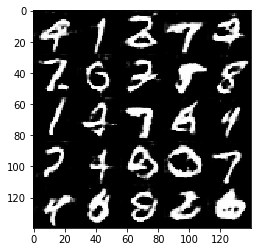

Epoch 2/2... Batch 1810... Discriminator Loss: 0.7988... Generator Loss: 1.9624
Epoch 2/2... Batch 1820... Discriminator Loss: 1.8294... Generator Loss: 0.4084
Epoch 2/2... Batch 1830... Discriminator Loss: 1.8448... Generator Loss: 0.3853
Epoch 2/2... Batch 1840... Discriminator Loss: 0.6257... Generator Loss: 1.8470
Epoch 2/2... Batch 1850... Discriminator Loss: 0.7396... Generator Loss: 1.4091
Epoch 2/2... Batch 1860... Discriminator Loss: 0.7373... Generator Loss: 1.4147
Epoch 2/2... Batch 1870... Discriminator Loss: 0.9776... Generator Loss: 1.0223


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.01
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Data shape:  (202599, 28, 28, 3)
Epoch 1/1... Batch 10... Discriminator Loss: 1.9639... Generator Loss: 8.4855
Epoch 1/1... Batch 20... Discriminator Loss: 4.6842... Generator Loss: 0.0601
Epoch 1/1... Batch 30... Discriminator Loss: 1.5228... Generator Loss: 1.3465
Epoch 1/1... Batch 40... Discriminator Loss: 0.7839... Generator Loss: 1.8320
Epoch 1/1... Batch 50... Discriminator Loss: 1.2984... Generator Loss: 0.6939
Epoch 1/1... Batch 60... Discriminator Loss: 0.7020... Generator Loss: 2.4768
Epoch 1/1... Batch 70... Discriminator Loss: 1.7453... Generator Loss: 0.4788
Epoch 1/1... Batch 80... Discriminator Loss: 0.9200... Generator Loss: 1.7436
Epoch 1/1... Batch 90... Discriminator Loss: 1.4724... Generator Loss: 0.7801
Epoch 1/1... Batch 100... Discriminator Loss: 1.0908... Generator Loss: 1.5505


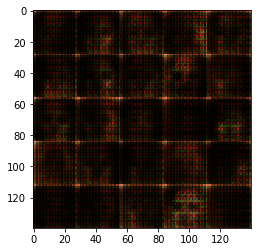

Epoch 1/1... Batch 110... Discriminator Loss: 2.4652... Generator Loss: 0.2696
Epoch 1/1... Batch 120... Discriminator Loss: 0.9626... Generator Loss: 2.1402
Epoch 1/1... Batch 130... Discriminator Loss: 1.2133... Generator Loss: 0.7924
Epoch 1/1... Batch 140... Discriminator Loss: 1.1295... Generator Loss: 2.0732
Epoch 1/1... Batch 150... Discriminator Loss: 1.1070... Generator Loss: 1.3684
Epoch 1/1... Batch 160... Discriminator Loss: 1.2760... Generator Loss: 0.6901
Epoch 1/1... Batch 170... Discriminator Loss: 1.1400... Generator Loss: 0.9205
Epoch 1/1... Batch 180... Discriminator Loss: 1.3104... Generator Loss: 0.6418
Epoch 1/1... Batch 190... Discriminator Loss: 1.3894... Generator Loss: 0.5815
Epoch 1/1... Batch 200... Discriminator Loss: 1.1157... Generator Loss: 0.8915


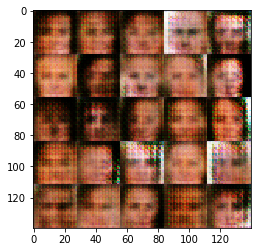

Epoch 1/1... Batch 210... Discriminator Loss: 1.2807... Generator Loss: 0.6909
Epoch 1/1... Batch 220... Discriminator Loss: 1.3276... Generator Loss: 0.9254
Epoch 1/1... Batch 230... Discriminator Loss: 1.2250... Generator Loss: 1.2847
Epoch 1/1... Batch 240... Discriminator Loss: 1.1976... Generator Loss: 0.8688
Epoch 1/1... Batch 250... Discriminator Loss: 1.1504... Generator Loss: 0.7906
Epoch 1/1... Batch 260... Discriminator Loss: 1.3348... Generator Loss: 0.5959
Epoch 1/1... Batch 270... Discriminator Loss: 1.5399... Generator Loss: 2.0837
Epoch 1/1... Batch 280... Discriminator Loss: 0.9250... Generator Loss: 1.0743
Epoch 1/1... Batch 290... Discriminator Loss: 1.3297... Generator Loss: 1.3585
Epoch 1/1... Batch 300... Discriminator Loss: 1.1029... Generator Loss: 1.0810


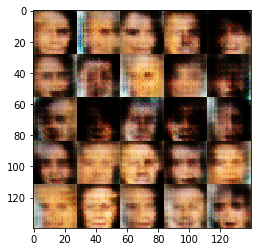

Epoch 1/1... Batch 310... Discriminator Loss: 1.0573... Generator Loss: 0.7975
Epoch 1/1... Batch 320... Discriminator Loss: 1.1089... Generator Loss: 1.0423
Epoch 1/1... Batch 330... Discriminator Loss: 1.4638... Generator Loss: 0.7179
Epoch 1/1... Batch 340... Discriminator Loss: 1.5986... Generator Loss: 0.4446
Epoch 1/1... Batch 350... Discriminator Loss: 1.8595... Generator Loss: 0.6207
Epoch 1/1... Batch 360... Discriminator Loss: 1.2651... Generator Loss: 1.1057
Epoch 1/1... Batch 370... Discriminator Loss: 1.1544... Generator Loss: 1.2573
Epoch 1/1... Batch 380... Discriminator Loss: 1.0093... Generator Loss: 0.8930
Epoch 1/1... Batch 390... Discriminator Loss: 0.8520... Generator Loss: 1.2199
Epoch 1/1... Batch 400... Discriminator Loss: 1.1552... Generator Loss: 2.0184


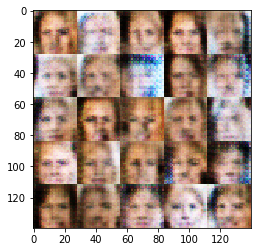

Epoch 1/1... Batch 410... Discriminator Loss: 1.3754... Generator Loss: 0.8338
Epoch 1/1... Batch 420... Discriminator Loss: 1.3450... Generator Loss: 0.5794
Epoch 1/1... Batch 430... Discriminator Loss: 1.0568... Generator Loss: 1.4505
Epoch 1/1... Batch 440... Discriminator Loss: 1.1675... Generator Loss: 0.9594
Epoch 1/1... Batch 450... Discriminator Loss: 1.2890... Generator Loss: 0.6883
Epoch 1/1... Batch 460... Discriminator Loss: 1.1563... Generator Loss: 1.0402
Epoch 1/1... Batch 470... Discriminator Loss: 1.1226... Generator Loss: 0.8345
Epoch 1/1... Batch 480... Discriminator Loss: 1.6026... Generator Loss: 0.6151
Epoch 1/1... Batch 490... Discriminator Loss: 1.8431... Generator Loss: 0.4083
Epoch 1/1... Batch 500... Discriminator Loss: 1.2191... Generator Loss: 1.0483


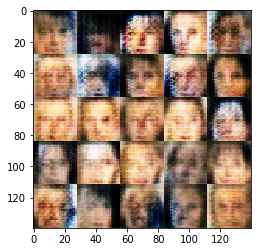

Epoch 1/1... Batch 510... Discriminator Loss: 1.2643... Generator Loss: 0.6776
Epoch 1/1... Batch 520... Discriminator Loss: 1.3636... Generator Loss: 0.8496
Epoch 1/1... Batch 530... Discriminator Loss: 1.4515... Generator Loss: 0.8704
Epoch 1/1... Batch 540... Discriminator Loss: 1.1732... Generator Loss: 0.9441
Epoch 1/1... Batch 550... Discriminator Loss: 1.3262... Generator Loss: 0.7379
Epoch 1/1... Batch 560... Discriminator Loss: 1.2716... Generator Loss: 1.1307
Epoch 1/1... Batch 570... Discriminator Loss: 1.5557... Generator Loss: 0.5799
Epoch 1/1... Batch 580... Discriminator Loss: 1.2610... Generator Loss: 0.8616
Epoch 1/1... Batch 590... Discriminator Loss: 1.3056... Generator Loss: 0.6994
Epoch 1/1... Batch 600... Discriminator Loss: 1.1763... Generator Loss: 1.2336


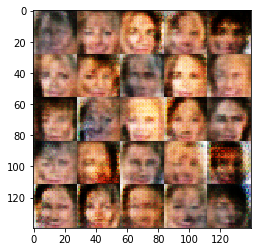

Epoch 1/1... Batch 610... Discriminator Loss: 1.5479... Generator Loss: 0.5695
Epoch 1/1... Batch 620... Discriminator Loss: 1.2213... Generator Loss: 0.8351
Epoch 1/1... Batch 630... Discriminator Loss: 1.6282... Generator Loss: 0.6411
Epoch 1/1... Batch 640... Discriminator Loss: 1.2633... Generator Loss: 1.0315
Epoch 1/1... Batch 650... Discriminator Loss: 1.5360... Generator Loss: 0.6146
Epoch 1/1... Batch 660... Discriminator Loss: 1.1079... Generator Loss: 1.0561
Epoch 1/1... Batch 670... Discriminator Loss: 1.7289... Generator Loss: 1.5813
Epoch 1/1... Batch 680... Discriminator Loss: 1.4733... Generator Loss: 0.5458
Epoch 1/1... Batch 690... Discriminator Loss: 1.2805... Generator Loss: 1.7442
Epoch 1/1... Batch 700... Discriminator Loss: 1.3089... Generator Loss: 1.0114


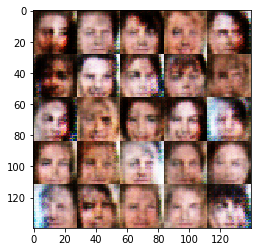

Epoch 1/1... Batch 710... Discriminator Loss: 1.1709... Generator Loss: 0.7811
Epoch 1/1... Batch 720... Discriminator Loss: 1.4121... Generator Loss: 0.8779
Epoch 1/1... Batch 730... Discriminator Loss: 0.9079... Generator Loss: 1.1179
Epoch 1/1... Batch 740... Discriminator Loss: 1.4003... Generator Loss: 1.2767
Epoch 1/1... Batch 750... Discriminator Loss: 1.1181... Generator Loss: 1.1831
Epoch 1/1... Batch 760... Discriminator Loss: 1.2287... Generator Loss: 0.8243
Epoch 1/1... Batch 770... Discriminator Loss: 1.2638... Generator Loss: 0.9652
Epoch 1/1... Batch 780... Discriminator Loss: 1.3680... Generator Loss: 0.7607
Epoch 1/1... Batch 790... Discriminator Loss: 1.2518... Generator Loss: 0.9774
Epoch 1/1... Batch 800... Discriminator Loss: 1.0881... Generator Loss: 0.9347


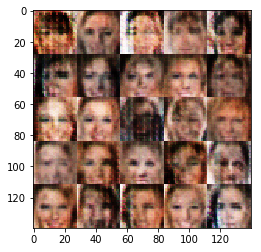

Epoch 1/1... Batch 810... Discriminator Loss: 1.3475... Generator Loss: 0.6617
Epoch 1/1... Batch 820... Discriminator Loss: 1.5311... Generator Loss: 1.9289
Epoch 1/1... Batch 830... Discriminator Loss: 1.4130... Generator Loss: 0.7098
Epoch 1/1... Batch 840... Discriminator Loss: 1.2395... Generator Loss: 0.8409
Epoch 1/1... Batch 850... Discriminator Loss: 1.3921... Generator Loss: 0.6037
Epoch 1/1... Batch 860... Discriminator Loss: 1.0748... Generator Loss: 1.0677
Epoch 1/1... Batch 870... Discriminator Loss: 1.7004... Generator Loss: 1.6644
Epoch 1/1... Batch 880... Discriminator Loss: 1.2016... Generator Loss: 1.0125
Epoch 1/1... Batch 890... Discriminator Loss: 1.3125... Generator Loss: 0.9471
Epoch 1/1... Batch 900... Discriminator Loss: 1.2668... Generator Loss: 0.7595


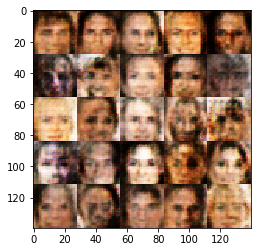

Epoch 1/1... Batch 910... Discriminator Loss: 1.2659... Generator Loss: 0.9880
Epoch 1/1... Batch 920... Discriminator Loss: 1.0812... Generator Loss: 1.0047
Epoch 1/1... Batch 930... Discriminator Loss: 1.2644... Generator Loss: 0.7075
Epoch 1/1... Batch 940... Discriminator Loss: 1.2650... Generator Loss: 0.7694
Epoch 1/1... Batch 950... Discriminator Loss: 0.9444... Generator Loss: 0.9808
Epoch 1/1... Batch 960... Discriminator Loss: 1.6928... Generator Loss: 1.6912
Epoch 1/1... Batch 970... Discriminator Loss: 1.1776... Generator Loss: 0.9888
Epoch 1/1... Batch 980... Discriminator Loss: 1.1922... Generator Loss: 0.7728
Epoch 1/1... Batch 990... Discriminator Loss: 1.4185... Generator Loss: 0.7742
Epoch 1/1... Batch 1000... Discriminator Loss: 1.1001... Generator Loss: 0.9167


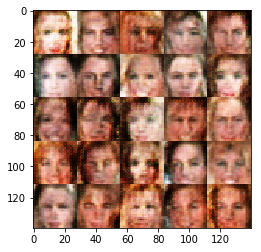

Epoch 1/1... Batch 1010... Discriminator Loss: 1.3582... Generator Loss: 0.7858
Epoch 1/1... Batch 1020... Discriminator Loss: 1.2401... Generator Loss: 0.8554
Epoch 1/1... Batch 1030... Discriminator Loss: 1.3594... Generator Loss: 0.6083
Epoch 1/1... Batch 1040... Discriminator Loss: 1.5666... Generator Loss: 0.6158
Epoch 1/1... Batch 1050... Discriminator Loss: 1.3082... Generator Loss: 0.7725
Epoch 1/1... Batch 1060... Discriminator Loss: 1.1291... Generator Loss: 1.0127
Epoch 1/1... Batch 1070... Discriminator Loss: 1.3279... Generator Loss: 0.7828
Epoch 1/1... Batch 1080... Discriminator Loss: 1.3629... Generator Loss: 1.1690
Epoch 1/1... Batch 1090... Discriminator Loss: 1.0944... Generator Loss: 0.9942
Epoch 1/1... Batch 1100... Discriminator Loss: 1.4366... Generator Loss: 0.6472


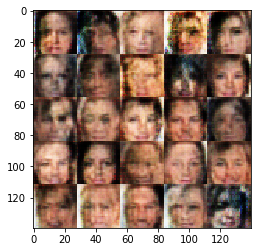

Epoch 1/1... Batch 1110... Discriminator Loss: 1.2971... Generator Loss: 0.5503
Epoch 1/1... Batch 1120... Discriminator Loss: 1.5391... Generator Loss: 0.7375
Epoch 1/1... Batch 1130... Discriminator Loss: 1.2530... Generator Loss: 0.6897
Epoch 1/1... Batch 1140... Discriminator Loss: 1.3840... Generator Loss: 1.3625
Epoch 1/1... Batch 1150... Discriminator Loss: 1.3150... Generator Loss: 0.8305
Epoch 1/1... Batch 1160... Discriminator Loss: 1.3125... Generator Loss: 0.8664
Epoch 1/1... Batch 1170... Discriminator Loss: 1.3931... Generator Loss: 0.6149
Epoch 1/1... Batch 1180... Discriminator Loss: 1.2894... Generator Loss: 1.2028
Epoch 1/1... Batch 1190... Discriminator Loss: 1.2571... Generator Loss: 0.9310
Epoch 1/1... Batch 1200... Discriminator Loss: 1.2818... Generator Loss: 0.9110


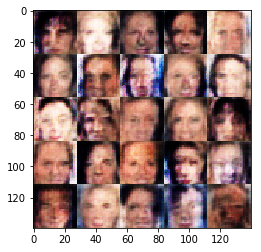

Epoch 1/1... Batch 1210... Discriminator Loss: 1.1551... Generator Loss: 0.9735
Epoch 1/1... Batch 1220... Discriminator Loss: 1.3469... Generator Loss: 0.6194
Epoch 1/1... Batch 1230... Discriminator Loss: 1.4711... Generator Loss: 0.8583
Epoch 1/1... Batch 1240... Discriminator Loss: 1.1454... Generator Loss: 1.6159
Epoch 1/1... Batch 1250... Discriminator Loss: 1.4755... Generator Loss: 0.7012
Epoch 1/1... Batch 1260... Discriminator Loss: 1.3557... Generator Loss: 0.6962
Epoch 1/1... Batch 1270... Discriminator Loss: 1.2807... Generator Loss: 1.0284
Epoch 1/1... Batch 1280... Discriminator Loss: 1.2852... Generator Loss: 1.2183
Epoch 1/1... Batch 1290... Discriminator Loss: 1.2684... Generator Loss: 0.8045
Epoch 1/1... Batch 1300... Discriminator Loss: 1.2085... Generator Loss: 0.9915


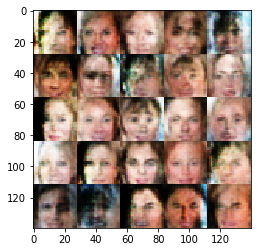

Epoch 1/1... Batch 1310... Discriminator Loss: 1.2544... Generator Loss: 0.8401
Epoch 1/1... Batch 1320... Discriminator Loss: 1.2274... Generator Loss: 1.4325
Epoch 1/1... Batch 1330... Discriminator Loss: 1.3832... Generator Loss: 0.6084
Epoch 1/1... Batch 1340... Discriminator Loss: 1.1455... Generator Loss: 0.7950
Epoch 1/1... Batch 1350... Discriminator Loss: 1.2825... Generator Loss: 0.9840
Epoch 1/1... Batch 1360... Discriminator Loss: 1.2150... Generator Loss: 0.7248
Epoch 1/1... Batch 1370... Discriminator Loss: 1.2206... Generator Loss: 0.7212
Epoch 1/1... Batch 1380... Discriminator Loss: 1.1935... Generator Loss: 0.6367
Epoch 1/1... Batch 1390... Discriminator Loss: 1.4294... Generator Loss: 0.6447
Epoch 1/1... Batch 1400... Discriminator Loss: 1.2938... Generator Loss: 0.9485


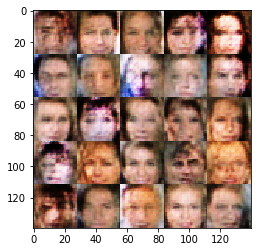

Epoch 1/1... Batch 1410... Discriminator Loss: 1.4460... Generator Loss: 0.8914
Epoch 1/1... Batch 1420... Discriminator Loss: 1.4499... Generator Loss: 0.5199
Epoch 1/1... Batch 1430... Discriminator Loss: 1.1531... Generator Loss: 0.7206
Epoch 1/1... Batch 1440... Discriminator Loss: 1.3059... Generator Loss: 0.5986
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2654... Generator Loss: 0.9296
Epoch 1/1... Batch 1460... Discriminator Loss: 1.0927... Generator Loss: 0.7939
Epoch 1/1... Batch 1470... Discriminator Loss: 1.2347... Generator Loss: 1.1205
Epoch 1/1... Batch 1480... Discriminator Loss: 1.4230... Generator Loss: 0.5114
Epoch 1/1... Batch 1490... Discriminator Loss: 1.3861... Generator Loss: 0.5457
Epoch 1/1... Batch 1500... Discriminator Loss: 1.3645... Generator Loss: 0.6387


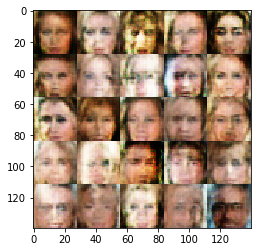

Epoch 1/1... Batch 1510... Discriminator Loss: 1.1290... Generator Loss: 1.0073
Epoch 1/1... Batch 1520... Discriminator Loss: 1.2669... Generator Loss: 0.9070
Epoch 1/1... Batch 1530... Discriminator Loss: 1.3045... Generator Loss: 0.6715
Epoch 1/1... Batch 1540... Discriminator Loss: 1.2145... Generator Loss: 0.9681
Epoch 1/1... Batch 1550... Discriminator Loss: 1.1347... Generator Loss: 0.9206
Epoch 1/1... Batch 1560... Discriminator Loss: 1.3711... Generator Loss: 1.3187
Epoch 1/1... Batch 1570... Discriminator Loss: 1.2677... Generator Loss: 1.2531
Epoch 1/1... Batch 1580... Discriminator Loss: 1.3089... Generator Loss: 1.0182
Epoch 1/1... Batch 1590... Discriminator Loss: 1.1121... Generator Loss: 0.9205
Epoch 1/1... Batch 1600... Discriminator Loss: 1.4876... Generator Loss: 0.8488


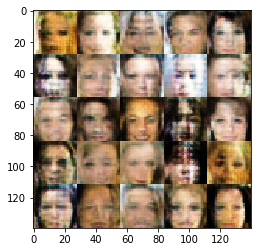

Epoch 1/1... Batch 1610... Discriminator Loss: 1.2065... Generator Loss: 0.8642
Epoch 1/1... Batch 1620... Discriminator Loss: 1.1619... Generator Loss: 0.8493
Epoch 1/1... Batch 1630... Discriminator Loss: 1.5670... Generator Loss: 0.3989
Epoch 1/1... Batch 1640... Discriminator Loss: 1.1613... Generator Loss: 0.9304
Epoch 1/1... Batch 1650... Discriminator Loss: 1.4169... Generator Loss: 0.7216
Epoch 1/1... Batch 1660... Discriminator Loss: 1.1884... Generator Loss: 0.7284
Epoch 1/1... Batch 1670... Discriminator Loss: 1.3217... Generator Loss: 0.8613
Epoch 1/1... Batch 1680... Discriminator Loss: 1.2744... Generator Loss: 1.3634
Epoch 1/1... Batch 1690... Discriminator Loss: 1.1955... Generator Loss: 0.9960
Epoch 1/1... Batch 1700... Discriminator Loss: 1.2732... Generator Loss: 0.8229


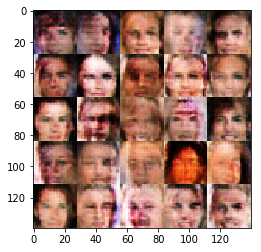

Epoch 1/1... Batch 1710... Discriminator Loss: 1.3950... Generator Loss: 0.5333
Epoch 1/1... Batch 1720... Discriminator Loss: 1.3460... Generator Loss: 0.8323
Epoch 1/1... Batch 1730... Discriminator Loss: 1.3120... Generator Loss: 0.6770
Epoch 1/1... Batch 1740... Discriminator Loss: 1.0543... Generator Loss: 1.1942
Epoch 1/1... Batch 1750... Discriminator Loss: 1.6037... Generator Loss: 0.3995
Epoch 1/1... Batch 1760... Discriminator Loss: 1.1599... Generator Loss: 0.8186
Epoch 1/1... Batch 1770... Discriminator Loss: 1.1550... Generator Loss: 0.9610
Epoch 1/1... Batch 1780... Discriminator Loss: 1.3238... Generator Loss: 1.0263
Epoch 1/1... Batch 1790... Discriminator Loss: 1.2946... Generator Loss: 1.0685
Epoch 1/1... Batch 1800... Discriminator Loss: 1.2256... Generator Loss: 0.8812


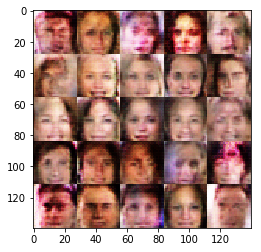

Epoch 1/1... Batch 1810... Discriminator Loss: 1.9776... Generator Loss: 0.2657
Epoch 1/1... Batch 1820... Discriminator Loss: 1.4854... Generator Loss: 0.5416
Epoch 1/1... Batch 1830... Discriminator Loss: 1.2686... Generator Loss: 1.0845
Epoch 1/1... Batch 1840... Discriminator Loss: 1.6173... Generator Loss: 0.3729
Epoch 1/1... Batch 1850... Discriminator Loss: 1.3900... Generator Loss: 0.8407
Epoch 1/1... Batch 1860... Discriminator Loss: 1.2012... Generator Loss: 0.7842
Epoch 1/1... Batch 1870... Discriminator Loss: 1.6380... Generator Loss: 0.4497
Epoch 1/1... Batch 1880... Discriminator Loss: 1.3346... Generator Loss: 0.8086
Epoch 1/1... Batch 1890... Discriminator Loss: 1.3751... Generator Loss: 0.5879
Epoch 1/1... Batch 1900... Discriminator Loss: 1.1478... Generator Loss: 0.9874


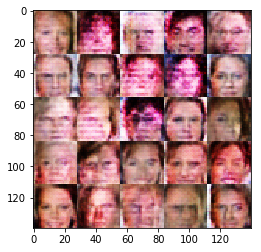

Epoch 1/1... Batch 1910... Discriminator Loss: 1.5350... Generator Loss: 1.6448
Epoch 1/1... Batch 1920... Discriminator Loss: 1.3442... Generator Loss: 0.8218
Epoch 1/1... Batch 1930... Discriminator Loss: 1.1829... Generator Loss: 1.0252
Epoch 1/1... Batch 1940... Discriminator Loss: 1.2499... Generator Loss: 0.9091
Epoch 1/1... Batch 1950... Discriminator Loss: 1.4370... Generator Loss: 0.5181
Epoch 1/1... Batch 1960... Discriminator Loss: 1.3248... Generator Loss: 0.9811
Epoch 1/1... Batch 1970... Discriminator Loss: 1.2699... Generator Loss: 0.9612
Epoch 1/1... Batch 1980... Discriminator Loss: 1.4070... Generator Loss: 0.5791
Epoch 1/1... Batch 1990... Discriminator Loss: 1.2995... Generator Loss: 0.6283
Epoch 1/1... Batch 2000... Discriminator Loss: 1.3530... Generator Loss: 0.7585


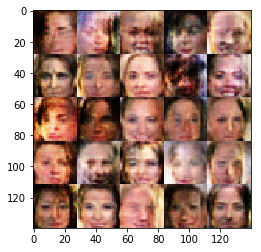

Epoch 1/1... Batch 2010... Discriminator Loss: 1.3635... Generator Loss: 0.6118
Epoch 1/1... Batch 2020... Discriminator Loss: 1.4021... Generator Loss: 0.6908
Epoch 1/1... Batch 2030... Discriminator Loss: 1.1386... Generator Loss: 1.2249
Epoch 1/1... Batch 2040... Discriminator Loss: 1.2938... Generator Loss: 0.6754
Epoch 1/1... Batch 2050... Discriminator Loss: 1.2208... Generator Loss: 1.1649
Epoch 1/1... Batch 2060... Discriminator Loss: 1.0103... Generator Loss: 0.8716
Epoch 1/1... Batch 2070... Discriminator Loss: 1.2067... Generator Loss: 0.8211
Epoch 1/1... Batch 2080... Discriminator Loss: 1.2715... Generator Loss: 0.7697
Epoch 1/1... Batch 2090... Discriminator Loss: 1.2221... Generator Loss: 1.1174
Epoch 1/1... Batch 2100... Discriminator Loss: 1.3082... Generator Loss: 1.0233


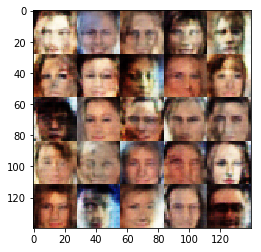

Epoch 1/1... Batch 2110... Discriminator Loss: 1.5653... Generator Loss: 0.5685
Epoch 1/1... Batch 2120... Discriminator Loss: 1.1684... Generator Loss: 0.7718
Epoch 1/1... Batch 2130... Discriminator Loss: 1.2483... Generator Loss: 0.8415
Epoch 1/1... Batch 2140... Discriminator Loss: 1.1547... Generator Loss: 0.9395
Epoch 1/1... Batch 2150... Discriminator Loss: 1.2051... Generator Loss: 0.7451
Epoch 1/1... Batch 2160... Discriminator Loss: 1.1688... Generator Loss: 1.0631
Epoch 1/1... Batch 2170... Discriminator Loss: 1.2748... Generator Loss: 0.7649
Epoch 1/1... Batch 2180... Discriminator Loss: 1.1699... Generator Loss: 1.0043
Epoch 1/1... Batch 2190... Discriminator Loss: 1.4289... Generator Loss: 1.4465
Epoch 1/1... Batch 2200... Discriminator Loss: 1.2484... Generator Loss: 1.0332


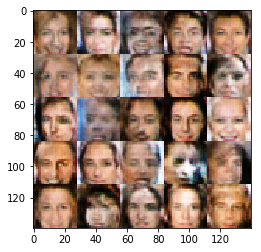

Epoch 1/1... Batch 2210... Discriminator Loss: 1.4497... Generator Loss: 0.6036
Epoch 1/1... Batch 2220... Discriminator Loss: 1.1537... Generator Loss: 1.1273
Epoch 1/1... Batch 2230... Discriminator Loss: 1.3424... Generator Loss: 0.6013
Epoch 1/1... Batch 2240... Discriminator Loss: 1.1575... Generator Loss: 0.8334
Epoch 1/1... Batch 2250... Discriminator Loss: 1.1435... Generator Loss: 1.3422
Epoch 1/1... Batch 2260... Discriminator Loss: 1.1351... Generator Loss: 1.1738
Epoch 1/1... Batch 2270... Discriminator Loss: 1.4093... Generator Loss: 1.2374
Epoch 1/1... Batch 2280... Discriminator Loss: 1.2355... Generator Loss: 1.3752
Epoch 1/1... Batch 2290... Discriminator Loss: 1.1190... Generator Loss: 1.0232
Epoch 1/1... Batch 2300... Discriminator Loss: 1.1195... Generator Loss: 1.2255


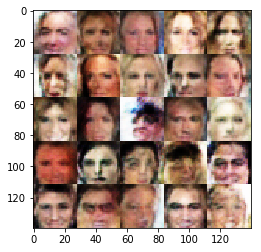

Epoch 1/1... Batch 2310... Discriminator Loss: 1.3188... Generator Loss: 0.7423
Epoch 1/1... Batch 2320... Discriminator Loss: 1.1702... Generator Loss: 0.8111
Epoch 1/1... Batch 2330... Discriminator Loss: 1.2042... Generator Loss: 0.9449
Epoch 1/1... Batch 2340... Discriminator Loss: 1.1768... Generator Loss: 1.2665
Epoch 1/1... Batch 2350... Discriminator Loss: 1.2365... Generator Loss: 0.8293
Epoch 1/1... Batch 2360... Discriminator Loss: 1.1735... Generator Loss: 0.8429
Epoch 1/1... Batch 2370... Discriminator Loss: 1.5657... Generator Loss: 0.9284
Epoch 1/1... Batch 2380... Discriminator Loss: 1.3363... Generator Loss: 0.6591
Epoch 1/1... Batch 2390... Discriminator Loss: 1.4774... Generator Loss: 0.4668
Epoch 1/1... Batch 2400... Discriminator Loss: 1.0628... Generator Loss: 0.9354


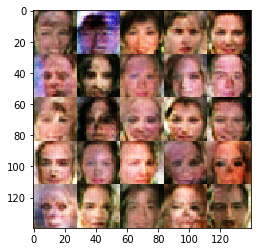

Epoch 1/1... Batch 2410... Discriminator Loss: 1.5512... Generator Loss: 0.4308
Epoch 1/1... Batch 2420... Discriminator Loss: 1.3381... Generator Loss: 0.5992
Epoch 1/1... Batch 2430... Discriminator Loss: 1.2461... Generator Loss: 0.7461
Epoch 1/1... Batch 2440... Discriminator Loss: 1.4804... Generator Loss: 0.4876
Epoch 1/1... Batch 2450... Discriminator Loss: 1.3878... Generator Loss: 0.6464
Epoch 1/1... Batch 2460... Discriminator Loss: 1.1428... Generator Loss: 0.7897
Epoch 1/1... Batch 2470... Discriminator Loss: 1.2391... Generator Loss: 0.9656
Epoch 1/1... Batch 2480... Discriminator Loss: 1.1737... Generator Loss: 0.8409
Epoch 1/1... Batch 2490... Discriminator Loss: 1.1963... Generator Loss: 0.8141
Epoch 1/1... Batch 2500... Discriminator Loss: 1.4656... Generator Loss: 1.5022


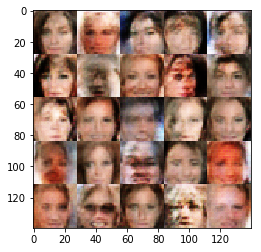

Epoch 1/1... Batch 2510... Discriminator Loss: 1.1525... Generator Loss: 1.5849
Epoch 1/1... Batch 2520... Discriminator Loss: 1.5812... Generator Loss: 0.3987
Epoch 1/1... Batch 2530... Discriminator Loss: 1.2062... Generator Loss: 0.7687
Epoch 1/1... Batch 2540... Discriminator Loss: 1.3657... Generator Loss: 0.5164
Epoch 1/1... Batch 2550... Discriminator Loss: 1.3023... Generator Loss: 0.6647
Epoch 1/1... Batch 2560... Discriminator Loss: 1.4995... Generator Loss: 0.6853
Epoch 1/1... Batch 2570... Discriminator Loss: 1.2433... Generator Loss: 1.0888
Epoch 1/1... Batch 2580... Discriminator Loss: 1.1862... Generator Loss: 0.9608
Epoch 1/1... Batch 2590... Discriminator Loss: 1.3511... Generator Loss: 0.5615
Epoch 1/1... Batch 2600... Discriminator Loss: 1.2077... Generator Loss: 0.8754


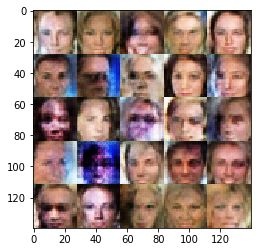

Epoch 1/1... Batch 2610... Discriminator Loss: 1.3186... Generator Loss: 0.9696
Epoch 1/1... Batch 2620... Discriminator Loss: 1.6150... Generator Loss: 0.4079
Epoch 1/1... Batch 2630... Discriminator Loss: 1.1647... Generator Loss: 0.9352
Epoch 1/1... Batch 2640... Discriminator Loss: 1.0725... Generator Loss: 1.1710
Epoch 1/1... Batch 2650... Discriminator Loss: 1.3891... Generator Loss: 0.6365
Epoch 1/1... Batch 2660... Discriminator Loss: 1.5438... Generator Loss: 0.5059
Epoch 1/1... Batch 2670... Discriminator Loss: 1.2685... Generator Loss: 0.7932
Epoch 1/1... Batch 2680... Discriminator Loss: 1.3560... Generator Loss: 0.6591
Epoch 1/1... Batch 2690... Discriminator Loss: 1.2720... Generator Loss: 0.8298
Epoch 1/1... Batch 2700... Discriminator Loss: 1.4097... Generator Loss: 0.6117


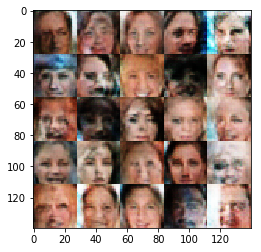

Epoch 1/1... Batch 2710... Discriminator Loss: 1.3771... Generator Loss: 0.5586
Epoch 1/1... Batch 2720... Discriminator Loss: 1.1401... Generator Loss: 0.8411
Epoch 1/1... Batch 2730... Discriminator Loss: 1.3416... Generator Loss: 1.0118
Epoch 1/1... Batch 2740... Discriminator Loss: 1.2886... Generator Loss: 0.6705
Epoch 1/1... Batch 2750... Discriminator Loss: 1.2313... Generator Loss: 0.6782
Epoch 1/1... Batch 2760... Discriminator Loss: 1.4040... Generator Loss: 0.5248
Epoch 1/1... Batch 2770... Discriminator Loss: 1.4419... Generator Loss: 0.4853
Epoch 1/1... Batch 2780... Discriminator Loss: 1.2493... Generator Loss: 0.8255
Epoch 1/1... Batch 2790... Discriminator Loss: 1.2915... Generator Loss: 1.3486
Epoch 1/1... Batch 2800... Discriminator Loss: 1.2194... Generator Loss: 1.1114


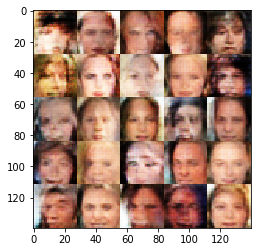

Epoch 1/1... Batch 2810... Discriminator Loss: 1.2783... Generator Loss: 0.9104
Epoch 1/1... Batch 2820... Discriminator Loss: 1.2373... Generator Loss: 1.0028
Epoch 1/1... Batch 2830... Discriminator Loss: 1.1630... Generator Loss: 1.0256
Epoch 1/1... Batch 2840... Discriminator Loss: 1.4623... Generator Loss: 0.4837
Epoch 1/1... Batch 2850... Discriminator Loss: 1.2554... Generator Loss: 0.8924
Epoch 1/1... Batch 2860... Discriminator Loss: 1.4479... Generator Loss: 0.4935
Epoch 1/1... Batch 2870... Discriminator Loss: 0.9886... Generator Loss: 1.4214
Epoch 1/1... Batch 2880... Discriminator Loss: 1.3639... Generator Loss: 0.5879
Epoch 1/1... Batch 2890... Discriminator Loss: 1.2280... Generator Loss: 0.9844
Epoch 1/1... Batch 2900... Discriminator Loss: 1.1257... Generator Loss: 1.0165


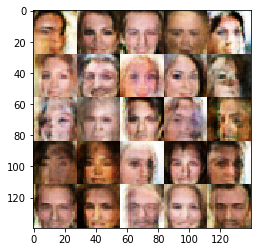

Epoch 1/1... Batch 2910... Discriminator Loss: 1.2583... Generator Loss: 0.8436
Epoch 1/1... Batch 2920... Discriminator Loss: 1.3810... Generator Loss: 0.5594
Epoch 1/1... Batch 2930... Discriminator Loss: 1.3742... Generator Loss: 0.5964
Epoch 1/1... Batch 2940... Discriminator Loss: 1.3391... Generator Loss: 1.0120
Epoch 1/1... Batch 2950... Discriminator Loss: 1.2634... Generator Loss: 1.0897
Epoch 1/1... Batch 2960... Discriminator Loss: 1.3559... Generator Loss: 0.6247
Epoch 1/1... Batch 2970... Discriminator Loss: 1.1438... Generator Loss: 0.8904
Epoch 1/1... Batch 2980... Discriminator Loss: 1.2183... Generator Loss: 0.9866
Epoch 1/1... Batch 2990... Discriminator Loss: 1.4134... Generator Loss: 0.8048
Epoch 1/1... Batch 3000... Discriminator Loss: 1.2285... Generator Loss: 1.0988


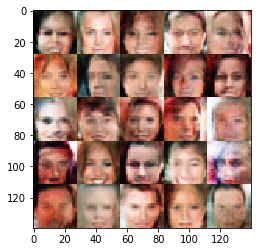

Epoch 1/1... Batch 3010... Discriminator Loss: 1.3365... Generator Loss: 0.8051
Epoch 1/1... Batch 3020... Discriminator Loss: 1.2532... Generator Loss: 0.7223
Epoch 1/1... Batch 3030... Discriminator Loss: 1.3283... Generator Loss: 0.8248
Epoch 1/1... Batch 3040... Discriminator Loss: 1.1238... Generator Loss: 1.3477
Epoch 1/1... Batch 3050... Discriminator Loss: 1.3980... Generator Loss: 0.6223
Epoch 1/1... Batch 3060... Discriminator Loss: 1.3765... Generator Loss: 0.5629
Epoch 1/1... Batch 3070... Discriminator Loss: 1.2593... Generator Loss: 0.8302
Epoch 1/1... Batch 3080... Discriminator Loss: 1.4697... Generator Loss: 0.5144
Epoch 1/1... Batch 3090... Discriminator Loss: 1.3217... Generator Loss: 0.6978
Epoch 1/1... Batch 3100... Discriminator Loss: 1.0974... Generator Loss: 0.9646


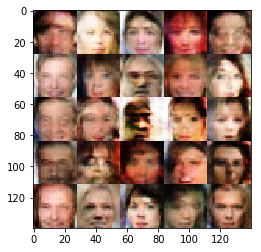

Epoch 1/1... Batch 3110... Discriminator Loss: 1.1495... Generator Loss: 0.9742
Epoch 1/1... Batch 3120... Discriminator Loss: 1.1672... Generator Loss: 1.3047
Epoch 1/1... Batch 3130... Discriminator Loss: 1.3456... Generator Loss: 1.1114
Epoch 1/1... Batch 3140... Discriminator Loss: 1.4269... Generator Loss: 0.7628
Epoch 1/1... Batch 3150... Discriminator Loss: 1.1628... Generator Loss: 1.0050
Epoch 1/1... Batch 3160... Discriminator Loss: 1.2455... Generator Loss: 0.7082
Epoch 1/1... Batch 3170... Discriminator Loss: 1.4729... Generator Loss: 1.3989
Epoch 1/1... Batch 3180... Discriminator Loss: 1.2557... Generator Loss: 0.8313
Epoch 1/1... Batch 3190... Discriminator Loss: 1.3302... Generator Loss: 0.6109
Epoch 1/1... Batch 3200... Discriminator Loss: 1.1381... Generator Loss: 1.1155


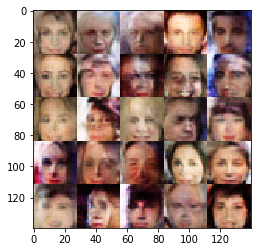

Epoch 1/1... Batch 3210... Discriminator Loss: 1.3780... Generator Loss: 0.6433
Epoch 1/1... Batch 3220... Discriminator Loss: 1.2070... Generator Loss: 0.8581
Epoch 1/1... Batch 3230... Discriminator Loss: 1.2339... Generator Loss: 0.6765
Epoch 1/1... Batch 3240... Discriminator Loss: 1.4881... Generator Loss: 0.4793
Epoch 1/1... Batch 3250... Discriminator Loss: 1.1971... Generator Loss: 0.9971
Epoch 1/1... Batch 3260... Discriminator Loss: 1.2235... Generator Loss: 0.8128
Epoch 1/1... Batch 3270... Discriminator Loss: 1.2907... Generator Loss: 0.6368
Epoch 1/1... Batch 3280... Discriminator Loss: 1.2468... Generator Loss: 0.9576
Epoch 1/1... Batch 3290... Discriminator Loss: 1.3417... Generator Loss: 0.8327
Epoch 1/1... Batch 3300... Discriminator Loss: 1.2878... Generator Loss: 0.9293


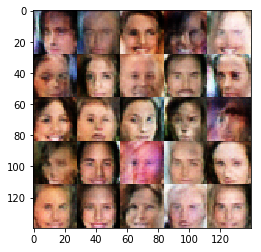

Epoch 1/1... Batch 3310... Discriminator Loss: 1.2710... Generator Loss: 0.6562
Epoch 1/1... Batch 3320... Discriminator Loss: 1.1477... Generator Loss: 0.7669
Epoch 1/1... Batch 3330... Discriminator Loss: 1.3020... Generator Loss: 1.3022
Epoch 1/1... Batch 3340... Discriminator Loss: 1.3696... Generator Loss: 0.8514
Epoch 1/1... Batch 3350... Discriminator Loss: 1.3551... Generator Loss: 0.8530
Epoch 1/1... Batch 3360... Discriminator Loss: 1.1903... Generator Loss: 0.8790
Epoch 1/1... Batch 3370... Discriminator Loss: 1.2179... Generator Loss: 0.9254
Epoch 1/1... Batch 3380... Discriminator Loss: 1.0502... Generator Loss: 1.1592
Epoch 1/1... Batch 4900... Discriminator Loss: 1.3510... Generator Loss: 0.6472


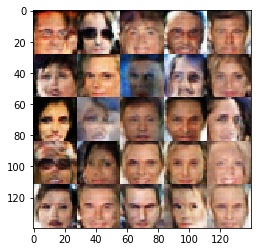

Epoch 1/1... Batch 4910... Discriminator Loss: 1.4801... Generator Loss: 0.7939
Epoch 1/1... Batch 4920... Discriminator Loss: 1.1275... Generator Loss: 1.0549
Epoch 1/1... Batch 4930... Discriminator Loss: 1.1145... Generator Loss: 0.8642
Epoch 1/1... Batch 4940... Discriminator Loss: 1.4063... Generator Loss: 0.5748
Epoch 1/1... Batch 4950... Discriminator Loss: 1.0554... Generator Loss: 1.0668
Epoch 1/1... Batch 4960... Discriminator Loss: 1.2152... Generator Loss: 0.8760
Epoch 1/1... Batch 4970... Discriminator Loss: 1.3071... Generator Loss: 0.6843
Epoch 1/1... Batch 4980... Discriminator Loss: 1.1692... Generator Loss: 0.9531
Epoch 1/1... Batch 4990... Discriminator Loss: 1.2569... Generator Loss: 0.7347
Epoch 1/1... Batch 5000... Discriminator Loss: 1.1693... Generator Loss: 0.9606


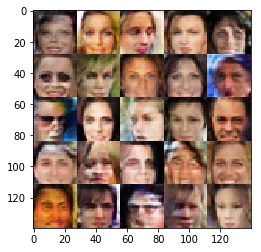

Epoch 1/1... Batch 5010... Discriminator Loss: 1.3518... Generator Loss: 0.9526
Epoch 1/1... Batch 5020... Discriminator Loss: 1.2743... Generator Loss: 0.6909
Epoch 1/1... Batch 5030... Discriminator Loss: 1.2464... Generator Loss: 0.7216
Epoch 1/1... Batch 5040... Discriminator Loss: 1.0807... Generator Loss: 1.1887
Epoch 1/1... Batch 5050... Discriminator Loss: 1.2714... Generator Loss: 0.6421
Epoch 1/1... Batch 5060... Discriminator Loss: 1.3054... Generator Loss: 0.6206
Epoch 1/1... Batch 5070... Discriminator Loss: 1.3120... Generator Loss: 0.6543
Epoch 1/1... Batch 5080... Discriminator Loss: 1.1534... Generator Loss: 0.8187
Epoch 1/1... Batch 5090... Discriminator Loss: 1.3038... Generator Loss: 0.7392
Epoch 1/1... Batch 5100... Discriminator Loss: 1.1022... Generator Loss: 0.8575


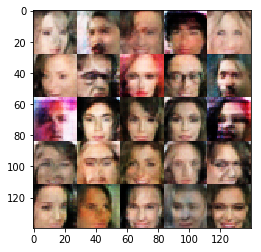

Epoch 1/1... Batch 5110... Discriminator Loss: 1.1430... Generator Loss: 0.8210
Epoch 1/1... Batch 5120... Discriminator Loss: 1.2188... Generator Loss: 1.1218
Epoch 1/1... Batch 5130... Discriminator Loss: 1.3347... Generator Loss: 0.8073
Epoch 1/1... Batch 5140... Discriminator Loss: 1.3554... Generator Loss: 0.6608
Epoch 1/1... Batch 5150... Discriminator Loss: 1.2599... Generator Loss: 0.7608
Epoch 1/1... Batch 5160... Discriminator Loss: 1.2305... Generator Loss: 0.8157
Epoch 1/1... Batch 5170... Discriminator Loss: 1.2712... Generator Loss: 0.7303
Epoch 1/1... Batch 5180... Discriminator Loss: 1.3644... Generator Loss: 0.8462
Epoch 1/1... Batch 5190... Discriminator Loss: 1.2039... Generator Loss: 1.0240
Epoch 1/1... Batch 5200... Discriminator Loss: 0.9067... Generator Loss: 1.4246


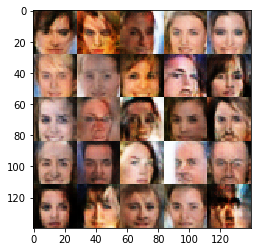

Epoch 1/1... Batch 5210... Discriminator Loss: 1.2427... Generator Loss: 0.7381
Epoch 1/1... Batch 5220... Discriminator Loss: 1.3305... Generator Loss: 0.6999
Epoch 1/1... Batch 5230... Discriminator Loss: 1.1629... Generator Loss: 0.8979
Epoch 1/1... Batch 5240... Discriminator Loss: 1.1150... Generator Loss: 0.8409
Epoch 1/1... Batch 5250... Discriminator Loss: 1.3283... Generator Loss: 0.7149
Epoch 1/1... Batch 5260... Discriminator Loss: 1.2211... Generator Loss: 0.7258
Epoch 1/1... Batch 5270... Discriminator Loss: 1.3909... Generator Loss: 0.8756
Epoch 1/1... Batch 5280... Discriminator Loss: 1.1833... Generator Loss: 0.9123
Epoch 1/1... Batch 5290... Discriminator Loss: 1.3043... Generator Loss: 0.7921
Epoch 1/1... Batch 5300... Discriminator Loss: 1.2738... Generator Loss: 0.7100


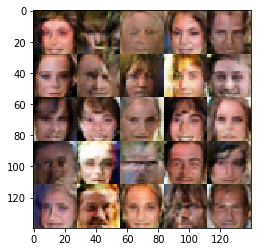

Epoch 1/1... Batch 5310... Discriminator Loss: 1.3501... Generator Loss: 0.6910
Epoch 1/1... Batch 5320... Discriminator Loss: 1.1512... Generator Loss: 0.9495
Epoch 1/1... Batch 5330... Discriminator Loss: 1.3002... Generator Loss: 0.6795
Epoch 1/1... Batch 5340... Discriminator Loss: 1.1566... Generator Loss: 0.9907
Epoch 1/1... Batch 5350... Discriminator Loss: 1.3538... Generator Loss: 0.5586
Epoch 1/1... Batch 5360... Discriminator Loss: 1.3556... Generator Loss: 0.8616
Epoch 1/1... Batch 5370... Discriminator Loss: 1.1779... Generator Loss: 0.8860
Epoch 1/1... Batch 5380... Discriminator Loss: 1.3769... Generator Loss: 0.5048
Epoch 1/1... Batch 5390... Discriminator Loss: 1.1953... Generator Loss: 1.2343
Epoch 1/1... Batch 5400... Discriminator Loss: 1.4506... Generator Loss: 0.5169


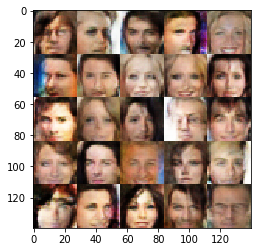

Epoch 1/1... Batch 5410... Discriminator Loss: 1.3149... Generator Loss: 0.6660
Epoch 1/1... Batch 5420... Discriminator Loss: 1.2454... Generator Loss: 0.9424
Epoch 1/1... Batch 5430... Discriminator Loss: 1.1360... Generator Loss: 0.7708
Epoch 1/1... Batch 5440... Discriminator Loss: 1.2296... Generator Loss: 0.6697
Epoch 1/1... Batch 5450... Discriminator Loss: 1.3174... Generator Loss: 0.9933
Epoch 1/1... Batch 5460... Discriminator Loss: 1.3183... Generator Loss: 0.7592
Epoch 1/1... Batch 5470... Discriminator Loss: 1.3712... Generator Loss: 0.6782
Epoch 1/1... Batch 5480... Discriminator Loss: 1.6086... Generator Loss: 0.4101
Epoch 1/1... Batch 5490... Discriminator Loss: 1.3839... Generator Loss: 0.6584
Epoch 1/1... Batch 5500... Discriminator Loss: 1.0988... Generator Loss: 1.0528


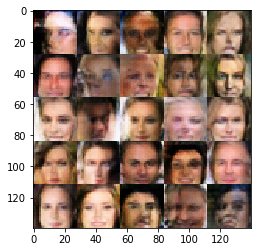

Epoch 1/1... Batch 5510... Discriminator Loss: 1.3024... Generator Loss: 0.5982
Epoch 1/1... Batch 5520... Discriminator Loss: 1.2004... Generator Loss: 0.7155
Epoch 1/1... Batch 5530... Discriminator Loss: 1.2807... Generator Loss: 0.6437
Epoch 1/1... Batch 5540... Discriminator Loss: 1.4422... Generator Loss: 0.5124
Epoch 1/1... Batch 5550... Discriminator Loss: 1.2509... Generator Loss: 0.7351
Epoch 1/1... Batch 5560... Discriminator Loss: 1.2626... Generator Loss: 1.0493
Epoch 1/1... Batch 5570... Discriminator Loss: 1.1211... Generator Loss: 0.8779
Epoch 1/1... Batch 5580... Discriminator Loss: 1.1024... Generator Loss: 0.9103
Epoch 1/1... Batch 5590... Discriminator Loss: 1.1038... Generator Loss: 0.9083
Epoch 1/1... Batch 5600... Discriminator Loss: 1.1994... Generator Loss: 0.9008


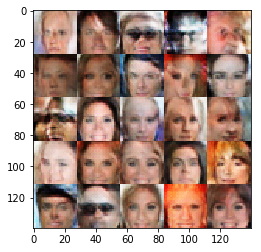

Epoch 1/1... Batch 5610... Discriminator Loss: 1.2030... Generator Loss: 0.8231
Epoch 1/1... Batch 5620... Discriminator Loss: 1.2683... Generator Loss: 0.8646
Epoch 1/1... Batch 5630... Discriminator Loss: 1.1683... Generator Loss: 0.8938
Epoch 1/1... Batch 5640... Discriminator Loss: 1.2933... Generator Loss: 0.8939
Epoch 1/1... Batch 5650... Discriminator Loss: 1.2638... Generator Loss: 0.8432
Epoch 1/1... Batch 5660... Discriminator Loss: 1.3249... Generator Loss: 0.5896
Epoch 1/1... Batch 5670... Discriminator Loss: 1.1485... Generator Loss: 1.0202
Epoch 1/1... Batch 5680... Discriminator Loss: 1.1632... Generator Loss: 1.0809
Epoch 1/1... Batch 5690... Discriminator Loss: 1.3839... Generator Loss: 0.6349
Epoch 1/1... Batch 5700... Discriminator Loss: 1.3224... Generator Loss: 0.5780


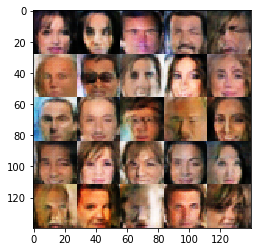

Epoch 1/1... Batch 5710... Discriminator Loss: 1.2835... Generator Loss: 0.7212
Epoch 1/1... Batch 5720... Discriminator Loss: 1.3121... Generator Loss: 0.5371
Epoch 1/1... Batch 5730... Discriminator Loss: 1.2153... Generator Loss: 0.8624
Epoch 1/1... Batch 5740... Discriminator Loss: 1.3040... Generator Loss: 0.7354
Epoch 1/1... Batch 5750... Discriminator Loss: 1.2693... Generator Loss: 0.7390
Epoch 1/1... Batch 5760... Discriminator Loss: 0.8898... Generator Loss: 1.3221
Epoch 1/1... Batch 5770... Discriminator Loss: 1.3183... Generator Loss: 0.8798
Epoch 1/1... Batch 5780... Discriminator Loss: 1.0525... Generator Loss: 0.9999
Epoch 1/1... Batch 5790... Discriminator Loss: 1.4221... Generator Loss: 0.5433
Epoch 1/1... Batch 5800... Discriminator Loss: 1.1354... Generator Loss: 0.8663


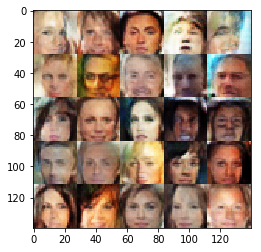

Epoch 1/1... Batch 5810... Discriminator Loss: 1.2650... Generator Loss: 0.7627
Epoch 1/1... Batch 5820... Discriminator Loss: 1.1484... Generator Loss: 1.0410
Epoch 1/1... Batch 5830... Discriminator Loss: 1.2057... Generator Loss: 0.6859
Epoch 1/1... Batch 5840... Discriminator Loss: 1.2426... Generator Loss: 0.7441
Epoch 1/1... Batch 5850... Discriminator Loss: 1.2451... Generator Loss: 0.6130
Epoch 1/1... Batch 5860... Discriminator Loss: 1.3368... Generator Loss: 0.8092
Epoch 1/1... Batch 5870... Discriminator Loss: 1.2619... Generator Loss: 0.7829
Epoch 1/1... Batch 5880... Discriminator Loss: 1.2334... Generator Loss: 0.9518
Epoch 1/1... Batch 5890... Discriminator Loss: 1.1350... Generator Loss: 0.8966
Epoch 1/1... Batch 5900... Discriminator Loss: 1.4431... Generator Loss: 0.5544


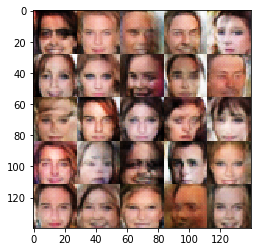

Epoch 1/1... Batch 5910... Discriminator Loss: 1.2387... Generator Loss: 0.7835
Epoch 1/1... Batch 5920... Discriminator Loss: 1.2772... Generator Loss: 0.7637
Epoch 1/1... Batch 5930... Discriminator Loss: 1.3800... Generator Loss: 0.5273
Epoch 1/1... Batch 5940... Discriminator Loss: 1.4612... Generator Loss: 0.4852
Epoch 1/1... Batch 5950... Discriminator Loss: 1.3144... Generator Loss: 0.5587
Epoch 1/1... Batch 5960... Discriminator Loss: 1.2985... Generator Loss: 0.6974
Epoch 1/1... Batch 5970... Discriminator Loss: 1.1476... Generator Loss: 0.7704
Epoch 1/1... Batch 5980... Discriminator Loss: 1.2106... Generator Loss: 1.2345
Epoch 1/1... Batch 5990... Discriminator Loss: 1.2078... Generator Loss: 0.7174
Epoch 1/1... Batch 6000... Discriminator Loss: 1.1888... Generator Loss: 0.7806


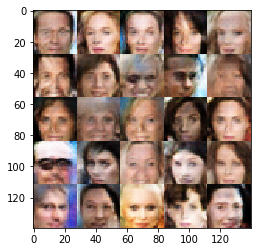

Epoch 1/1... Batch 6010... Discriminator Loss: 1.2973... Generator Loss: 0.6346
Epoch 1/1... Batch 6020... Discriminator Loss: 1.2560... Generator Loss: 0.6401
Epoch 1/1... Batch 6030... Discriminator Loss: 1.2209... Generator Loss: 1.0213
Epoch 1/1... Batch 6040... Discriminator Loss: 1.1195... Generator Loss: 0.9517
Epoch 1/1... Batch 6050... Discriminator Loss: 1.2314... Generator Loss: 1.1866
Epoch 1/1... Batch 6060... Discriminator Loss: 1.2092... Generator Loss: 1.3131
Epoch 1/1... Batch 6070... Discriminator Loss: 1.2381... Generator Loss: 1.0083
Epoch 1/1... Batch 6080... Discriminator Loss: 1.4129... Generator Loss: 0.7840
Epoch 1/1... Batch 6090... Discriminator Loss: 1.3408... Generator Loss: 0.6027
Epoch 1/1... Batch 6100... Discriminator Loss: 1.2967... Generator Loss: 0.5670


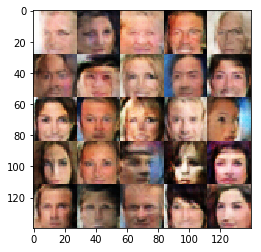

Epoch 1/1... Batch 6110... Discriminator Loss: 1.3363... Generator Loss: 0.5779
Epoch 1/1... Batch 6120... Discriminator Loss: 1.1047... Generator Loss: 1.0645
Epoch 1/1... Batch 6130... Discriminator Loss: 1.4075... Generator Loss: 0.9914
Epoch 1/1... Batch 6140... Discriminator Loss: 1.2267... Generator Loss: 0.7458
Epoch 1/1... Batch 6150... Discriminator Loss: 1.1750... Generator Loss: 0.8996
Epoch 1/1... Batch 6160... Discriminator Loss: 1.1265... Generator Loss: 1.0406
Epoch 1/1... Batch 6170... Discriminator Loss: 1.4724... Generator Loss: 0.5961
Epoch 1/1... Batch 6180... Discriminator Loss: 1.2795... Generator Loss: 0.8264
Epoch 1/1... Batch 6190... Discriminator Loss: 1.4383... Generator Loss: 0.4698
Epoch 1/1... Batch 6200... Discriminator Loss: 1.1389... Generator Loss: 0.8626


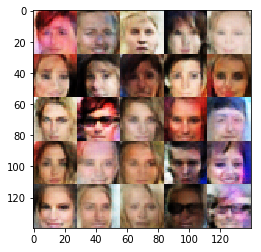

Epoch 1/1... Batch 6210... Discriminator Loss: 1.3209... Generator Loss: 0.6439
Epoch 1/1... Batch 6220... Discriminator Loss: 1.2617... Generator Loss: 0.6996
Epoch 1/1... Batch 6230... Discriminator Loss: 1.3444... Generator Loss: 0.7729
Epoch 1/1... Batch 6240... Discriminator Loss: 1.1069... Generator Loss: 0.8534
Epoch 1/1... Batch 6250... Discriminator Loss: 1.2813... Generator Loss: 0.6554
Epoch 1/1... Batch 6260... Discriminator Loss: 1.2576... Generator Loss: 0.7587
Epoch 1/1... Batch 6270... Discriminator Loss: 1.3538... Generator Loss: 0.5671
Epoch 1/1... Batch 6280... Discriminator Loss: 1.1340... Generator Loss: 0.9601
Epoch 1/1... Batch 6290... Discriminator Loss: 1.8059... Generator Loss: 0.3196
Epoch 1/1... Batch 6300... Discriminator Loss: 1.3658... Generator Loss: 0.6122


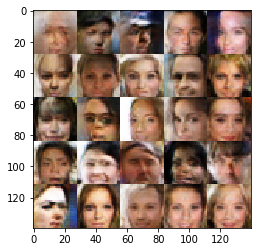

Epoch 1/1... Batch 6310... Discriminator Loss: 1.2243... Generator Loss: 0.8308
Epoch 1/1... Batch 6320... Discriminator Loss: 1.1051... Generator Loss: 0.8334
Epoch 1/1... Batch 6330... Discriminator Loss: 1.2208... Generator Loss: 0.7660


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.